|STUDENT NAME|STUDENT EMAIL|
|---|---|
|Daila Alexandre|r20191182@novaims.unl.pt|
|Diogo Silva|20221393@novaims.unl.pt|
|Luís Fernandes|20221649@novaims.unl.pt|

<h1 style="background-color: #FF5A60; color: white; font-size: 34px; font-weight: bold; padding: 10px;">Table of Contents</h1>

* [Essential](#test)
* [0. Instalations and Imports](#install)
* [1. Auxiliar Functions](#functions)
* [2. Preprocessing](#preprocess)
    * [2.1. Train dataset](#trainprepro)
        * [2.1.1. Language Detection](#train_langdetect)
        * [2.1.2. English Documents](#train_english)
        * [2.1.3. Translated Documents](#train_trans)
        * [2.1.4. Unfiltered Documents](#train_unfiltered)
        * [2.1.5. Filtered Documents](#train_filtered)
    * [2.2. Train Reviews dataset](#reviewsprepro)
        * [2.2.1. Complete Majority Vote](#reviews_comp_maj)
        * [2.2.2. Sample Majority Vote](#reviews_samp_maj)
        * [2.2.3. Complete Merge](#reviews_comp_merge)
        * [2.2.4. Sample Merge](#train_samp_merge)
* [3. Modeling Train dataset](#trainmodel)
    * [3.1. English](#model_train_eng)
        * [3.1.1. Grid Search (TF-IDF)](#grid_search)
        * [3.1.2. TF-IDF](#train_tf_idf)
            * [3.1.2.1. Oversampling](#train_tf_idf_over)
            * [3.1.2.2. Undersampling](#train_tf_idf_under)
        * [3.1.3. Word2Vec](#train_word_to_vec)
        * [3.1.4. BERT Tokenizer](#train_bert_tok)
        * [3.1.5. roBERTa Tokenizer](#train_roberta_tok)
        * [3.1.6. Host About (TF-IDF)](#train_host_tfidf)
        * [3.1.7. Description (TF-IDF)](#train_desc_tfidf)
        * [3.1.8. Translated (TF-IDF)](#train_trans_tfidf)
    * [3.2. Multiple Languages Unfiltered](#model_train_mul_unfil)
        * [3.2.1. M-BERT Tokenizer](#train_mbert_tok)
        * [3.2.2. XLM-roBERTa Tokenizer](#train_xlmroberta_tok)
    * [3.3. Multiple Languages Filtered](#model_train_mul_fil)
        * [3.3.1. M-BERT Tokenizer](#train_fil_mbert_tok)
        * [3.3.2. XLM-roBERTa Tokenizer](#train_fil_xlmroberta_tok)
    * [3.4. Finding the Best Model](#best_model_train)
        * [3.4.1. roBERTa Undersampling + Oversampling](#train_roberta_underover)
        * [3.4.2. Full M-BERT](#train_full_mbert)
        * [3.4.3. Full DistilBERT](#train_full_distilbert)
* [4. Modeling Train Reviews dataset](#reviewsmodel)
    * [4.1. Sample](#model_reviews_samp)
        * [4.1.1. roBERTa Majority Vote](#rev_robert_maj)
        * [4.1.2. roBERTa Merge](#rev_robert_merge)
    * [4.2. Complete](#model_reviews_comp)
        * [4.2.1. BalancedBaggingClassifier Merge](#rev_bbc_merge)
        * [4.2.2. Full M-BERT](#rev_full_mbert)
        * [4.2.3. Full DistilBERT](#rev_full_distilbert)
* [5. Ensemble](#ensemble)

<h1 id="test" style="background-color: #FF5A60; color: white; font-size: 34px; font-weight: bold; padding: 10px;">Essential</h1>

In [5]:
'''!pip install numpy==1.19.5
!pip install transformers sentencepiece nltk wordcloud matplotlib beautifulsoup4 html5lib spacy pyspellchecker langdetect googletrans==4.0.0-rc1 gensim

import nltk
nltk.download(['stopwords', 'punkt', 'wordnet', 'vader_lexicon', 'averaged_perceptron_tagger', 'universal_tagset'])
!pip install --upgrade torch transformers
'''
import warnings
import re
import string
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd

import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk import ngrams, FreqDist

from bs4 import BeautifulSoup

from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, LdaModel
from gensim.models import KeyedVectors

from googletrans import Translator

from langdetect import detect, LangDetectException

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn import svm
from sklearn.preprocessing import LabelEncoder

from plotly.subplots import make_subplots
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from scipy.sparse import hstack

from textblob import TextBlob

from wordcloud import WordCloud

from tqdm import tqdm

import spacy

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from transformers import BertTokenizer, BertModel

from nltk.tokenize import WordPunctTokenizer

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from spellchecker import SpellChecker

from dateutil.parser import parse

import joblib

import torch

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

from sklearn.svm import SVC
from scipy.stats import mode
from random import randint
import time
from transformers import RobertaTokenizer, RobertaModel
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# Ignore future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import logging
import transformers

# Set the logging level to ERROR
transformers.logging.set_verbosity_error()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [6]:
train = pd.read_excel('train.xlsx')
train.head(2)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1


In [8]:
train_reviews = pd.read_excel('train_reviews.xlsx')
train_reviews.head(2)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>


In [7]:
test = pd.read_excel('test.xlsx')
test.head(2)

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...


In [4]:
test_reviews = pd.read_excel('test_reviews.xlsx')
test_reviews.head(2)

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...


<h1 id="____" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">Pre-processing</h1>

In [9]:
def replace_money(text):
    # regex pattern to match currency values
    pattern = r'\b\d+(\.\d{1,2})? *(\$|euros?|reais?|dollars?|pounds?|yen|rupees?)\b'
    new_text = re.sub(pattern, '#money', text, flags=re.I)

    # If text has been altered, print original and new text
    return new_text

def replace_dates_times(text):
    # regex pattern to match date and time formats
    pattern = r'\b(\d{1,2}[-/]\d{1,2}[-/]\d{2,4}|\d{1,2}:\d{2}(:\d{2})?(?:\s*[ap]m)?|\d{1,2}(?:\s*[ap]m))\b'
    new_text = re.sub(pattern, '#datetime', text, flags=re.I)

    return new_text

def replace_emoticons(text):
    emoticon_patterns = {
        ":)": "#good",
        ": )": "#good",
        ":-)": "#good",
        ":]": "#good",
        ":D": "#good",
        ";)": "#good",
        ":(": "#bad",
        ": (": "#bad",
        ":'(": "#bad",
        ":/": "#bad",
        ":\\": "#bad",
        ":|": "#bad",
        ":p": "#good",
        ":P": "#good",
        ":s": "#bad",
        ":S": "#bad",
        "xD": "#good",
        "XD": "#good",
        "<3": "#good",
        ">:(": "#bad",
        ">:(": "#bad",
        ">:[": "#bad",
        ">:/": "#bad",
        ">:\\": "#bad",
        ">:{": "#bad",
        ">:[": "#bad"
        # Add more emoticon patterns as needed
    }

    # Replace emoticons with sentiment tags
    for emoticon, tag in emoticon_patterns.items():
        text = re.sub(re.escape(emoticon), tag, text)

    return text


#Function to remove Emjois
def remove_emojis(text):
    # Remove emojis from the text
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

class TextCleaning:
    def __init__(self):
        self

    def clean_text(self, text_list):
        cleaned_text = []

        for j in tqdm(text_list):
            # If text is NaN or empty, replace it with '#empty'
            if pd.isna(j) or not j.strip():
                cleaned_text.append('#empty')
                continue
            text = j
            # Lowercase text
            text = text.lower()

            # Remove numerical data, punctuation and URLs
            text = re.sub(r'http\S+', '', text)  #substitute all URLs in the text with an empty string.
            text = re.sub(r'\$\S+', '', text) #substitutes all substrings starting with a dollar sign ($)
            text = "".join([char for char in text if char not in string.punctuation])
            text = re.sub(r'[^\w\s]', '', text) #substitute all non-alphanumeric and non-whitespace characters with an empty string.
            text = re.sub(r'\d+', '', text)  #substitutes all substrings consisting of one or more digits (\d+) with an empty string.
            text= re.sub(r'\#\w+', '', text)
            text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
            text = " ".join([word for word in text.split() if len(word) >= 3]) #remove words with less than 3 characters

            #Replace dates and times
            text = replace_dates_times(text)

            #Replace money text
            text = replace_money(text)

            #Replace emoticons with sentiment tags
            text = replace_emoticons(text)

            #Remove the remain Emojis (as the ones not replaced with sentiments are not necessary)
            text = remove_emojis(text)

            cleaned_text.append(text)

        return cleaned_text

final_df_majority = train_reviews.copy()
# Clean and group comments by index
final_df_majority = train_reviews.copy()
final_df_majority['comments'] = final_df_majority['comments'].fillna('#empty')
final_df_majority['comments'] = final_df_majority['comments'].apply(lambda x: '#empty' if str(x).isspace() else x)
final_df_majority['comments'] = final_df_majority['comments'].astype(str)
final_df_majority['comments'] = final_df_majority['comments'].apply(replace_money)
final_df_majority['comments'] = final_df_majority['comments'].apply(replace_dates_times)
final_df_majority['comments'] = final_df_majority['comments'].apply(replace_emoticons)
grouped_comments = final_df_majority.groupby('index').agg({'comments': ' '.join})

# Merge grouped comments into final_df_merged
final_df_merged = pd.merge(train, grouped_comments, on='index', how='left')

# Fill NaN comments with '#empty'
final_df_merged['comments'] = final_df_merged['comments'].fillna('#empty')


# Apply the function to replace currency values in the 'description' column
final_df_merged['description_cleaned'] = final_df_merged['description'].apply(replace_money)
final_df_merged['host_about_cleaned'] = final_df_merged['host_about'].apply(replace_money)

# Apply the function to replace dates and times in the 'description' column
final_df_merged['description_cleaned'] = final_df_merged['description_cleaned'].apply(replace_dates_times)
final_df_merged['host_about_cleaned'] = final_df_merged['host_about_cleaned'].apply(replace_dates_times)

final_df_merged['description_cleaned'] = final_df_merged['description_cleaned'].apply(replace_emoticons)
final_df_merged['host_about_cleaned'] = final_df_merged['host_about_cleaned'].apply(replace_emoticons)


# Initialize TextCleaning instance
cleaner = TextCleaning()
final_df_merged['comments'] = cleaner.clean_text(final_df_merged['comments'])
# Clean the 'description' column
final_df_merged['description_cleaned'] = cleaner.clean_text(final_df_merged['description_cleaned'])
final_df_merged['host_about_cleaned'] = cleaner.clean_text(final_df_merged['host_about_cleaned'])

# Combine description and host_about columns
final_df_merged['description_host'] = final_df_merged['description_cleaned'] + ' ' + final_df_merged['host_about_cleaned']

100%|██████████| 12496/12496 [00:02<00:00, 4769.47it/s]


In [10]:
final_df_temp = test_reviews.copy()
# Clean and group comments by index
final_df_temp['comments'] = final_df_temp['comments'].fillna('#empty')
final_df_temp['comments'] = final_df_temp['comments'].apply(lambda x: '#empty' if str(x).isspace() else x)
final_df_temp['comments'] = final_df_temp['comments'].astype(str)
final_df_temp['comments'] = final_df_temp['comments'].apply(replace_money)
final_df_temp['comments'] = final_df_temp['comments'].apply(replace_dates_times)
final_df_temp['comments'] = final_df_temp['comments'].apply(replace_emoticons)
grouped_comments = final_df_temp.groupby('index').agg({'comments': ' '.join})

# Merge grouped comments into final_df
final_df = pd.merge(test['index'], grouped_comments, on='index', how='left')

# Fill NaN comments with '#empty'
final_df['comments'] = final_df['comments'].fillna('#empty')
# Initialize TextCleaning instance
cleaner = TextCleaning()
final_df['comments'] = cleaner.clean_text(final_df['comments'])

100%|██████████| 1389/1389 [00:06<00:00, 216.80it/s]


In [11]:
final_df.head(5)

,index,comments
0,1,thank you very much antonio all has been perfe...
1,2,this beautiful bright apartment more residenti...
2,3,empty
3,4,claudia was great host she met the train stati...
4,5,maison est exactement comme sur les photos ces...


<h1 id="____" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">Functions</h1>

In [12]:
# Define the general function to evaluate the models
def evaluate_model(y_true, y_pred):
    # Print the classification report
    print(classification_report(y_true, y_pred))
    print()

    # Print the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print()

    print("Model Evaluation:")
    print("Accuracy:", round(accuracy_score(y_true, y_pred),3))
    print("Precision:", round(precision_score(y_true, y_pred),3))
    print("Recall:", round(recall_score(y_true, y_pred),3))
    print("F1 Score:", round(f1_score(y_true, y_pred),3))
    print("ROC-AUC Score:", round(roc_auc_score(y_true, y_pred),3))

In [13]:
def tokenize_xlm_roberta(column, num):
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

    # Load pre-trained model (weights)
    model = XLMRobertaModel.from_pretrained('xlm-roberta-base', output_hidden_states=True)

    # Set the model in evaluation mode to deactivate the DropOut modules
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to GPU if available
    model = model.to(device)

    # Define a batch size
    batch_size = 32  # Adjust based on GPU memory

    def calculate_embeddings(texts):
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            # Create batch tensors with padding for uneven batches
            batch_input_ids = []
            batch_attention_mask = []

            for text in batch_texts:
                if text:
                    encoded_input = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                        return_tensors='pt',  # Return PyTorch tensors
                        max_length=512,  # Truncate texts to this length
                        padding='max_length',  # Pad shorter sentences
                        return_attention_mask=True,
                        truncation=True
                    )

                    # Add the encoded results to the batch lists
                    batch_input_ids.append(encoded_input['input_ids'])
                    batch_attention_mask.append(encoded_input['attention_mask'])
                else:
                    # Append zero tensors for empty texts
                    batch_input_ids.append(torch.zeros((1, 512), dtype=torch.long))
                    batch_attention_mask.append(torch.zeros((1, 512), dtype=torch.long))

            # Convert lists to tensors
            batch_input_ids = torch.cat(batch_input_ids, dim=0)
            batch_attention_mask = torch.cat(batch_attention_mask, dim=0)

            # Move tensors to GPU if available
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)

            # Predict hidden states features for each layer
            with torch.no_grad():
                outputs = model(batch_input_ids, batch_attention_mask)
                hidden_states = outputs[2]

            # Concatenate the tensors for all layers.
            token_embeddings = torch.stack(hidden_states, dim=0)

            # Swap dimensions 0 and 1.
            token_embeddings = token_embeddings.permute(1,2,0,3)

            # Take the first token ([CLS]) from the embeddings of the last layer
            sentence_embeddings = token_embeddings[:, 0, -1]

            # Move embeddings to CPU and convert to numpy arrays
            sentence_embeddings = sentence_embeddings.cpu().numpy()
            embeddings.extend(sentence_embeddings)

        return embeddings

    if num==1:
        X_train[column + '_xlmr'] = calculate_embeddings(X_train[column].tolist())
        X_train_combined_xlmr = np.vstack(X_train[column + '_xlmr'])

        return X_train_combined_xlmr

    if num==2:
        X_train[column + '_xlmr'] = calculate_embeddings(X_train[column].tolist())
        X_train_combined_xlmr = np.vstack(X_train[column + '_xlmr'])
        X_val[column + '_xlmr'] = calculate_embeddings(X_val[column].tolist())
        X_val_combined_xlmr = np.vstack(X_val[column + '_xlmr'])

        return X_train_combined_xlmr, X_val_combined_xlmr

<h1 id="____" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">Tokenizing, Spliting and Oversampling</h1>

In [14]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-multilingual-uncased', output_hidden_states=True)

# Set the model in evaluation mode to deactivate the DropOut modules
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU if available
model = model.to(device)

# Define a batch size
batch_size = 32  # Adjust based on GPU memory

def calculate_embeddings(texts):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Create batch tensors with padding for uneven batches
        batch_input_ids = []
        batch_attention_mask = []

        for text in batch_texts:
            if text:
                encoded_input = tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                    return_tensors='pt',  # Return PyTorch tensors
                    max_length=512,  # Truncate texts to this length
                    padding='max_length',  # Pad shorter sentences
                    return_attention_mask=True,
                    truncation=True
                )

                # Add the encoded results to the batch lists
                batch_input_ids.append(encoded_input['input_ids'])
                batch_attention_mask.append(encoded_input['attention_mask'])
            else:
                # Append zero tensors for empty texts
                batch_input_ids.append(torch.zeros((1, 512), dtype=torch.long))
                batch_attention_mask.append(torch.zeros((1, 512), dtype=torch.long))

        # Convert lists to tensors
        batch_input_ids = torch.cat(batch_input_ids, dim=0)
        batch_attention_mask = torch.cat(batch_attention_mask, dim=0)

        # Move tensors to GPU if available
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)

        # Predict hidden states features for each layer
        with torch.no_grad():
            outputs = model(batch_input_ids, batch_attention_mask)
            hidden_states = outputs[2]

        # Concatenate the tensors for all layers.
        token_embeddings = torch.stack(hidden_states, dim=0)

        # Swap dimensions 0 and 1.
        token_embeddings = token_embeddings.permute(1,2,0,3)

        # Take the first token ([CLS]) from the embeddings of the last layer
        sentence_embeddings = token_embeddings[:, 0, -1]

        # Move embeddings to CPU and convert to numpy arrays
        sentence_embeddings = sentence_embeddings.cpu().numpy()
        embeddings.extend(sentence_embeddings)

    return embeddings

test_roberta_tokenized = np.vstack(calculate_embeddings(final_df['comments'].tolist()))

In [30]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(final_df_merged,
    final_df_merged['unlisted'],
    test_size=0.2,
    random_state=42,
    stratify= final_df_merged['unlisted']
)

X_train_xlmr, X_val_xlmr = tokenize_xlm_roberta('comments',2 )


# Apply SMOTE to the training data (after vectorization)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_xlmr, y_train)

Train and evaluate the best model, then predict the labels for the test data.

In [22]:
best_params_bag_tf = {'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}

bbc_classifier = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier.fit(X_train_smote, y_train_smote)

y_pred = bbc_classifier.predict(X_val_xlmr)
evaluate_model(y_val, y_pred)

y_pred_comments = bbc_classifier.predict(test_roberta_tokenized)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1807
           1       0.70      0.83      0.76       693

    accuracy                           0.86      2500
   macro avg       0.82      0.85      0.83      2500
weighted avg       0.87      0.86      0.86      2500


Confusion Matrix:
[[1566  241]
 [ 121  572]]

Model Evaluation:
Accuracy: 0.855
Precision: 0.704
Recall: 0.825
F1 Score: 0.76
ROC-AUC Score: 0.846


Analyze results.

In [23]:
# Save the predictions to the respective indexes in df_test
final_df['unlisted_predictions'] = y_pred_comments
final_df.head(5)

,index,comments,unlisted_predictions
0,1,thank you very much antonio all has been perfe...,0
1,2,this beautiful bright apartment more residenti...,1
2,3,empty,1
3,4,claudia was great host she met the train stati...,0
4,5,maison est exactement comme sur les photos ces...,0


In [24]:
to_submit = pd.DataFrame()
to_submit['index'] = final_df['index']
to_submit['unlisted'] = final_df['unlisted_predictions']

In [25]:
len(final_df)

1389

In [26]:
len(test)

1389

In [27]:
to_submit.isna().sum()

index       0
unlisted    0
dtype: int64

In [28]:
print(to_submit['unlisted'].value_counts(normalize=True)*100)


1    69.546436
0    30.453564
Name: unlisted, dtype: float64


Save csv file.

In [29]:
to_submit.to_csv('/content/to_submit.csv', index=False)

<h1 id="install" style="background-color: #FF5A60; color: white; font-size: 34px; font-weight: bold; padding: 10px;">0. Instalations and Imports</h1>

In [ ]:
!pip install numpy==1.19.5
!pip install transformers sentencepiece nltk wordcloud matplotlib beautifulsoup4 html5lib spacy pyspellchecker langdetect googletrans==4.0.0-rc1 gensim
!pip install --upgrade torch transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 67.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import re
import string
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns

import nltk
nltk.download(['stopwords', 'punkt', 'wordnet', 'vader_lexicon', 'averaged_perceptron_tagger', 'universal_tagset'])
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk import ngrams, FreqDist

from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, LdaModel
from gensim.models import KeyedVectors

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

from plotly.subplots import make_subplots
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from scipy.sparse import hstack
from scipy.stats import mode
from textblob import TextBlob
from wordcloud import WordCloud
from tqdm import tqdm
import spacy
from bs4 import BeautifulSoup
from googletrans import Translator
from langdetect import detect, LangDetectException

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, XLMRobertaModel, BertModel, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import TFBertModel, BertConfig,TFDistilBertModel, DistilBertConfig
from transformers import RobertaTokenizer, RobertaModel
from transformers import BertForSequenceClassification, AdamW

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from spellchecker import SpellChecker
from dateutil.parser import parse
import joblib
from tensorflow.keras import regularizers
import torch
from random import randint
import time

import logging

# Set the logging level to ERROR
transformers.logging.set_verbosity_error()


/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning:

Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.

/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning:

Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.

/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning:

Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following co

<h1 id="functions" style="background-color: #FF5A60; color: white; font-size: 34px; font-weight: bold; padding: 10px;">1. Auxiliar Functions</h1>

Code to plot the f1-scores boxplots per label per model.

In [ ]:
def boxplot(X_plot,y_plot):
    warnings.filterwarnings('ignore', category=FutureWarning)

    classifiers = ['Logistic Regression','KNN','BalancedBagging', 'RandomForestClassifier', 'XGBClassifier',
               'Balance SVC','Balance RF','Balance Logistic']

    models = [LogisticRegression(**best_params_logistic_tf), KNeighborsClassifier(**best_params_knn_tf),
              BalancedBaggingClassifier(**best_params_bag_tf),
              RandomForestClassifier(**best_params_rf_tf), XGBClassifier(scale_pos_weight=weight),
              svm.SVC(class_weight='balanced'),RandomForestClassifier(class_weight='balanced', **best_params_rf_tf),
              LogisticRegression(class_weight='balanced', **best_params_logistic_tf)]

    f1_scores = {classifier: {'0': [], '1': []} for classifier in classifiers}

    #  cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(X_plot, y_plot):
        for model, classifier in zip(models, classifiers):
            clone_model = clone(model)
            X_train_folds = X_plot[train_index]
            y_train_folds = y_plot.values[train_index]
            X_test_fold = X_plot[test_index]
            y_test_fold = y_plot.values[test_index]

            clone_model.fit(X_train_folds, y_train_folds)
            y_pred = clone_model.predict(X_test_fold)
            report = classification_report(y_test_fold, y_pred, output_dict=True)

            # append f1 score of class '0' and '1' into the corresponding model and class
            f1_scores[classifier]['0'].append(report['0']['f1-score'])
            f1_scores[classifier]['1'].append(report['1']['f1-score'])

    plt.figure(figsize=(14, 7))

    colors = ['#4CAF50', '#FF0000']
    labels = ['0', '1']

    # Create a boxplot for each classifier
    for i, (classifier, scores) in enumerate(f1_scores.items()):
        bp1 = plt.boxplot(scores['0'], positions=[i*3], widths=0.6, patch_artist=True)
        bp2 = plt.boxplot(scores['1'], positions=[i*3 + 1], widths=0.6, patch_artist=True)

        # Set fill color for each boxplot
        for patch in bp1['boxes']:
            patch.set_facecolor(colors[0])
        for patch in bp2['boxes']:
            patch.set_facecolor(colors[1])

        # Set color and size for outliers
        for flier in bp1['fliers']:
            flier.set(marker='o', color='black',  alpha=0.6, markersize=4, markerfacecolor='black')
        for flier in bp2['fliers']:
            flier.set(marker='o', color='black',  alpha=0.6, markersize=4, markerfacecolor='black')

        # Set color for mean line
        plt.setp(bp1['medians'], color='black')
        plt.setp(bp2['medians'], color='black')

    # Label the x-axis with the classifier names
    plt.xticks(range(1, len(classifiers)*3, 3), classifiers)

    # Create custom artists for legend
    custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(labels))]

    # Create legend
    plt.legend(custom_lines, labels)

    # Set y-axis label
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()


Code to plot the f1-scores boxplots per label per model after oversampling - iloc has to be used.

In [ ]:
def boxplot_oversample(X_plot,y_plot):
    warnings.filterwarnings('ignore', category=FutureWarning)

    classifiers = ['Logistic Regression','KNN','BalancedBagging', 'RandomForestClassifier', 'XGBClassifier',
               'Balance SVC','Balance RF','Balance Logistic']

    models = [LogisticRegression(**best_params_logistic_tf), KNeighborsClassifier(**best_params_knn_tf),
              BalancedBaggingClassifier(**best_params_bag_tf),
              RandomForestClassifier(**best_params_rf_tf), XGBClassifier(scale_pos_weight=weight),
              svm.SVC(class_weight='balanced'),RandomForestClassifier(class_weight='balanced', **best_params_rf_tf),
              LogisticRegression(class_weight='balanced', **best_params_logistic_tf)]

    f1_scores = {classifier: {'0': [], '1': []} for classifier in classifiers}

    #  cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(X_plot, y_plot):
        for model, classifier in zip(models, classifiers):
            clone_model = clone(model)
            X_train_folds = X_plot.iloc[train_index]
            y_train_folds = y_plot.values[train_index]
            X_test_fold = X_plot.iloc[test_index]
            y_test_fold = y_plot.values[test_index]

            clone_model.fit(X_train_folds, y_train_folds)
            y_pred = clone_model.predict(X_test_fold)
            report = classification_report(y_test_fold, y_pred, output_dict=True)

            # append f1 score of class '0' and '1' into the corresponding model and class
            f1_scores[classifier]['0'].append(report['0']['f1-score'])
            f1_scores[classifier]['1'].append(report['1']['f1-score'])

    plt.figure(figsize=(14, 7))

    colors = ['#4CAF50', '#FF0000']
    labels = ['0', '1']

    # Create a boxplot for each classifier
    for i, (classifier, scores) in enumerate(f1_scores.items()):
        bp1 = plt.boxplot(scores['0'], positions=[i*3], widths=0.6, patch_artist=True)
        bp2 = plt.boxplot(scores['1'], positions=[i*3 + 1], widths=0.6, patch_artist=True)

        # Set fill color for each boxplot
        for patch in bp1['boxes']:
            patch.set_facecolor(colors[0])
        for patch in bp2['boxes']:
            patch.set_facecolor(colors[1])

        # Set color and size for outliers
        for flier in bp1['fliers']:
            flier.set(marker='o', color='black',  alpha=0.6, markersize=4, markerfacecolor='black')
        for flier in bp2['fliers']:
            flier.set(marker='o', color='black',  alpha=0.6, markersize=4, markerfacecolor='black')

        # Set color for mean line
        plt.setp(bp1['medians'], color='black')
        plt.setp(bp2['medians'], color='black')

    # Label the x-axis with the classifier names
    plt.xticks(range(1, len(classifiers)*3, 3), classifiers)

    # Create custom artists for legend
    custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(labels))]

    # Create legend
    plt.legend(custom_lines, labels)

    # Set y-axis label
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()


Code to plot the f1-scores boxplots per label per model after changing the predictions of the same index to the majority predicted.

In [ ]:
def boxplot_vote(X_plot,y_plot):
    warnings.filterwarnings('ignore', category=FutureWarning)

    classifiers = ['Logistic Regression', 'KNN', 'BalancedBagging', 'RandomForestClassifier', 'XGBClassifier',
                  'Balance SVC', 'Balance RF', 'Balance Logistic']

    models = [LogisticRegression(**best_params_logistic_tf), KNeighborsClassifier(**best_params_knn_tf),
              BalancedBaggingClassifier(**best_params_bag_tf),
              RandomForestClassifier(**best_params_rf_tf), XGBClassifier(scale_pos_weight=weight),
              svm.SVC(class_weight='balanced'), RandomForestClassifier(class_weight='balanced', **best_params_rf_tf),
              LogisticRegression(class_weight='balanced', **best_params_logistic_tf)]

    f1_scores = {classifier: {'0': [], '1': []} for classifier in classifiers}

    # Define a StratifiedKFold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # A dictionary to store all the predictions for each model
    all_preds = {classifier: [] for classifier in classifiers}

    for train_index, test_index in skf.split(X_train_tfidf, y_train):
        X_train_folds = X_train_tfidf[train_index]
        y_train_folds = y_train.values[train_index]
        X_test_fold = X_train_tfidf[test_index]
        y_test_fold = y_train.values[test_index]

        for model, classifier in zip(models, classifiers):
            clone_model = clone(model)
            clone_model.fit(X_train_folds, y_train_folds)
            y_pred = clone_model.predict(X_test_fold)

            # Convert predictions into a DataFrame
            pred_df = pd.DataFrame({'index': test_index, 'prediction': y_pred})

            # Aggregate predictions by taking the mode (most common prediction)
            final_predictions = pred_df.groupby('index')['prediction'].agg(lambda x: x.value_counts().index[0]).values

            # Calculate f1 scores using final_predictions
            report = classification_report(y_test_fold, final_predictions, output_dict=True)
            f1_scores[classifier]['0'].append(report['0']['f1-score'])
            f1_scores[classifier]['1'].append(report['1']['f1-score'])
            all_preds[classifier].extend(final_predictions.tolist())

    plt.figure(figsize=(14, 7))

    colors = ['#4CAF50', '#FF0000']
    labels = ['0', '1']

    # Create a boxplot for each classifier
    for i, (classifier, scores) in enumerate(f1_scores.items()):
        bp1 = plt.boxplot(scores['0'], positions=[i*3], widths=0.6, patch_artist=True)
        bp2 = plt.boxplot(scores['1'], positions=[i*3 + 1], widths=0.6, patch_artist=True)

        # Set fill color for each boxplot
        for patch in bp1['boxes']:
            patch.set_facecolor(colors[0])
        for patch in bp2['boxes']:
            patch.set_facecolor(colors[1])

        # Set color and size for outliers
        for flier in bp1['fliers']:
            flier.set(marker='o', color='black',  alpha=0.6, markersize=4, markerfacecolor='black')
        for flier in bp2['fliers']:
            flier.set(marker='o', color='black',  alpha=0.6, markersize=4, markerfacecolor='black')

        # Set color for mean line
        plt.setp(bp1['medians'], color='black')
        plt.setp(bp2['medians'], color='black')

    # Label the x-axis with the classifier names
    plt.xticks(range(1, len(classifiers)*3, 3), classifiers)

    # Create custom artists for legend
    custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(labels))]

    # Create legend
    plt.legend(custom_lines, labels)

    # Set y-axis label
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()


Function to evaluate the performance of the models, outputing the metrics per label and global, as well as the confusion matrix.

In [ ]:
# Define the general function to evaluate the models
def evaluate_model(y_true, y_pred):
    # Print the classification report
    print(classification_report(y_true, y_pred))
    print()

    # Print the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print()

    print("Model Evaluation:")
    print("Accuracy:", round(accuracy_score(y_true, y_pred),3))
    print("Precision:", round(precision_score(y_true, y_pred),3))
    print("Recall:", round(recall_score(y_true, y_pred),3))
    print("F1 Score:", round(f1_score(y_true, y_pred),3))
    print("ROC-AUC Score:", round(roc_auc_score(y_true, y_pred),3))

M-Bert Tokenizer.

In [ ]:
def tokenize_mbert(column, num):
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

    # Load pre-trained model (weights)
    model = BertModel.from_pretrained('bert-base-multilingual-uncased', output_hidden_states=True)

    # Set the model in evaluation mode to deactivate the DropOut modules
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to GPU if available
    model = model.to(device)

    # Define a batch size
    batch_size = 32  # Adjust based on GPU memory

    def calculate_embeddings(texts):
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            # Create batch tensors with padding for uneven batches
            batch_input_ids = []
            batch_attention_mask = []

            for text in batch_texts:
                if text:
                    encoded_input = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                        return_tensors='pt',  # Return PyTorch tensors
                        max_length=512,  # Truncate texts to this length
                        padding='max_length',  # Pad shorter sentences
                        return_attention_mask=True,
                        truncation=True
                    )

                    # Add the encoded results to the batch lists
                    batch_input_ids.append(encoded_input['input_ids'])
                    batch_attention_mask.append(encoded_input['attention_mask'])
                else:
                    # Append zero tensors for empty texts
                    batch_input_ids.append(torch.zeros((1, 512), dtype=torch.long))
                    batch_attention_mask.append(torch.zeros((1, 512), dtype=torch.long))

            # Convert lists to tensors
            batch_input_ids = torch.cat(batch_input_ids, dim=0)
            batch_attention_mask = torch.cat(batch_attention_mask, dim=0)

            # Move tensors to GPU if available
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)

            # Predict hidden states features for each layer
            with torch.no_grad():
                outputs = model(batch_input_ids, batch_attention_mask)
                hidden_states = outputs[2]

            # Concatenate the tensors for all layers.
            token_embeddings = torch.stack(hidden_states, dim=0)

            # Swap dimensions 0 and 1.
            token_embeddings = token_embeddings.permute(1,2,0,3)

            # Take the first token ([CLS]) from the embeddings of the last layer
            sentence_embeddings = token_embeddings[:, 0, -1]

            # Move embeddings to CPU and convert to numpy arrays
            sentence_embeddings = sentence_embeddings.cpu().numpy()
            embeddings.extend(sentence_embeddings)

        return embeddings

    if num==1:
        X_train[column + '_mbert'] = calculate_embeddings(X_train[column].tolist())
        X_train_combined_mbert = np.vstack(X_train[column + '_mbert'])

        return X_train_combined_mbert

    if num==2:
        X_train[column + '_mbert'] = calculate_embeddings(X_train[column].tolist())
        X_train_combined_mbert = np.vstack(X_train[column + '_mbert'])
        X_val[column + '_mbert'] = calculate_embeddings(X_val[column].tolist())
        X_val_combined_mbert = np.vstack(X_val[column + '_mbert'])

        return X_train_combined_mbert, X_val_combined_mbert

XLM-Roberta Tokenizer.

In [ ]:
def tokenize_xlm_roberta(column, num):
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

    # Load pre-trained model (weights)
    model = XLMRobertaModel.from_pretrained('xlm-roberta-base', output_hidden_states=True)

    # Set the model in evaluation mode to deactivate the DropOut modules
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to GPU if available
    model = model.to(device)

    # Define a batch size
    batch_size = 32  # Adjust based on GPU memory

    def calculate_embeddings(texts):
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            # Create batch tensors with padding for uneven batches
            batch_input_ids = []
            batch_attention_mask = []

            for text in batch_texts:
                if text:
                    encoded_input = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                        return_tensors='pt',  # Return PyTorch tensors
                        max_length=512,  # Truncate texts to this length
                        padding='max_length',  # Pad shorter sentences
                        return_attention_mask=True,
                        truncation=True
                    )

                    # Add the encoded results to the batch lists
                    batch_input_ids.append(encoded_input['input_ids'])
                    batch_attention_mask.append(encoded_input['attention_mask'])
                else:
                    # Append zero tensors for empty texts
                    batch_input_ids.append(torch.zeros((1, 512), dtype=torch.long))
                    batch_attention_mask.append(torch.zeros((1, 512), dtype=torch.long))

            # Convert lists to tensors
            batch_input_ids = torch.cat(batch_input_ids, dim=0)
            batch_attention_mask = torch.cat(batch_attention_mask, dim=0)

            # Move tensors to GPU if available
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)

            # Predict hidden states features for each layer
            with torch.no_grad():
                outputs = model(batch_input_ids, batch_attention_mask)
                hidden_states = outputs[2]

            # Concatenate the tensors for all layers.
            token_embeddings = torch.stack(hidden_states, dim=0)

            # Swap dimensions 0 and 1.
            token_embeddings = token_embeddings.permute(1,2,0,3)

            # Take the first token ([CLS]) from the embeddings of the last layer
            sentence_embeddings = token_embeddings[:, 0, -1]

            # Move embeddings to CPU and convert to numpy arrays
            sentence_embeddings = sentence_embeddings.cpu().numpy()
            embeddings.extend(sentence_embeddings)

        return embeddings

    if num==1:
        X_train[column + '_xlmr'] = calculate_embeddings(X_train[column].tolist())
        X_train_combined_xlmr = np.vstack(X_train[column + '_xlmr'])

        return X_train_combined_xlmr

    if num==2:
        X_train[column + '_xlmr'] = calculate_embeddings(X_train[column].tolist())
        X_train_combined_xlmr = np.vstack(X_train[column + '_xlmr'])
        X_val[column + '_xlmr'] = calculate_embeddings(X_val[column].tolist())
        X_val_combined_xlmr = np.vstack(X_val[column + '_xlmr'])

        return X_train_combined_xlmr, X_val_combined_xlmr

Read the excel files.

In [ ]:
train = pd.read_excel('train.xlsx')
train.head(5)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [ ]:
train_reviews = pd.read_excel('train_reviews.xlsx')
train_reviews.head(2)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>


<h1 id="preprocess" style="background-color: #FF5A60; color: white; font-size: 34px; font-weight: bold; padding: 10px;">2. Preprocessing</h1>

<h1 id="trainprepro" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">2.1. Train Dataset</h1>

<h3 id="train_langdetect" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">2.1.1. Language Detection</h3>

Creates 2 columns, with the languages of 'description' and 'host_about'.

In [ ]:
#function using except so it ignores empty values (such as seen in host_about)
def detect_lang(text):
    try:
        return detect(text)
    except:
        return None

# detect the language of text variables
train['description_language'] = train['description'].apply(lambda x: detect_lang(x))
train['host_about_language'] = train['host_about'].apply(lambda x: detect_lang(x))

<h3 id="train_english" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">2.1.2. English Documents</h3>

Any numeric value that corresponded to monetary values, such as ‘5$’, ‘3 euros’, and ‘200 reais’, were changed to ‘#money’, as well as dates in several formats, such as ‘16h00’, 05/06/22 and ‘5pm’ were converted to #datetime. Similarly, commonly used emojis such as 😀 and 😢 were changed to #good and #bad, respectively. Furthermore, making use of named entity frequency, characters recognized as numerical values were replaced to #number and locations identified as GPE (geo-political entities) and LOC (locations) are replaced with #place.

Afterwards, the text underwent several preprocessing steps, including the removal of the remaining emojis, numbers, HTML tags, links, English stop words, non-alphanumeric/non-whitespace characters and short words with less than three characters. Additionally, lemmatization was applied to retain the meaningful base form of the words, however, stemming was not applied in order to have a more linguistic accuracy and interpretation once stemming can produce non valid words.

This dataframe will be used in the section 'English Only'.

In [ ]:
def replace_money(text):
    # regex pattern to match currency values
    pattern = r'\b\d+(\.\d{1,2})? *(\$|euros?|reais?|dollars?|pounds?|yen|rupees?)\b'
    new_text = re.sub(pattern, '#money', text, flags=re.I)

    # If text has been altered, print original and new text
    return new_text

def replace_dates_times(text):
    # regex pattern to match date and time formats
    pattern = r'\b(\d{1,2}[-/]\d{1,2}[-/]\d{2,4}|\d{1,2}:\d{2}(:\d{2})?(?:\s*[ap]m)?|\d{1,2}(?:\s*[ap]m))\b'
    new_text = re.sub(pattern, '#datetime', text, flags=re.I)

    return new_text

def replace_emoticons(text):
    emoticon_patterns = {
        ":)": "#good",
        ": )": "#good",
        ":-)": "#good",
        ":]": "#good",
        ":D": "#good",
        ";)": "#good",
        ":(": "#bad",
        ": (": "#bad",
        ":'(": "#bad",
        ":/": "#bad",
        ":\\": "#bad",
        ":|": "#bad",
        ":p": "#good",
        ":P": "#good",
        ":s": "#bad",
        ":S": "#bad",
        "xD": "#good",
        "XD": "#good",
        "<3": "#good",
        ">:(": "#bad",
        ">:(": "#bad",
        ">:[": "#bad",
        ">:/": "#bad",
        ">:\\": "#bad",
        ">:{": "#bad",
        ">:[": "#bad"
        # Add more emoticon patterns as needed
    }

    # Replace emoticons with sentiment tags
    for emoticon, tag in emoticon_patterns.items():
        text = re.sub(re.escape(emoticon), tag, text)

    return text

# Load the language model
nlp_re = spacy.load('en_core_web_sm')

def replace_entities(text):
    doc = nlp_re(text)
    new_text = ""
    for token in doc:
        if token.ent_type_ == 'CARDINAL':
            new_text += "#number "
        elif token.ent_type_ == 'GPE' or token.ent_type_ == 'LOC':
            new_text += '#place '
        else:
            new_text += token.text + " "
    return new_text.strip()

#Function to remove Emjois
def remove_emojis(text):
    # Remove emojis from the text
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

class TextCleaning:
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('english')
        self.lemmatize = True
        self.stem = False

    def clean_text(self, text_list):
        cleaned_text = []

        for j in tqdm(text_list):
            # If text is NaN or empty, replace it with '#empty'
            if pd.isna(j) or not j.strip():
                cleaned_text.append('#empty')
                continue
            text = j
            # Lowercase text
            text = text.lower()

            # Remove numerical data, punctuation and URLs
            text = re.sub(r'http\S+', '', text)  #substitute all URLs in the text with an empty string.
            text = re.sub(r'\$\S+', '', text) #substitutes all substrings starting with a dollar sign ($)
            text = "".join([char for char in text if char not in string.punctuation])
            text = re.sub(r'[^\w\s]', '', text) #substitute all non-alphanumeric and non-whitespace characters with an empty string.
            text = re.sub(r'\d+', '', text)  #substitutes all substrings consisting of one or more digits (\d+) with an empty string.
            text= re.sub(r'\#\w+', '', text)
            text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
            text = " ".join([word for word in text.split() if len(word) >= 3]) #remove words with less than 3 characters

            #Replace dates and times
            text = replace_dates_times(text)

            #Replace money text
            text = replace_money(text)

            #Replace emoticons with sentiment tags
            text = replace_emoticons(text)

            #Remove the remain Emojis (as the ones not replaced with sentiments are not necessary)
            text = remove_emojis(text)

            #Apply the replace entities function created
            text = replace_entities(text)

            # Remove stopwords
            text = " ".join([word for word in text.split() if word not in self.stopwords])

            # Lemmatize text
            if self.lemmatize:
                text = " ".join(self.lemmatizer.lemmatize(word) for word in text.split())

            # Stem text
            if self.stem:
                text = " ".join(self.stemmer.stem(word) for word in text.split())

            cleaned_text.append(text)

        return cleaned_text

english_only_train = train[train['description_language'] == 'en']
english_only_train = english_only_train[english_only_train['host_about_language'] == 'en']

# Apply the function to replace currency values in the 'description' column
english_only_train['description_cleaned'] = english_only_train['description'].apply(replace_money)
english_only_train['host_about_cleaned'] = english_only_train['host_about'].apply(replace_money)

# Apply the function to replace dates and times in the 'description' column
english_only_train['description_cleaned'] = english_only_train['description_cleaned'].apply(replace_dates_times)
english_only_train['host_about_cleaned'] = english_only_train['host_about_cleaned'].apply(replace_dates_times)

english_only_train['description_cleaned'] = english_only_train['description_cleaned'].apply(replace_emoticons)
english_only_train['host_about_cleaned'] = english_only_train['host_about_cleaned'].apply(replace_emoticons)

# Apply the function to replace entities in the 'description' column
english_only_train['description_cleaned'] = english_only_train['description_cleaned'].apply(replace_entities)
english_only_train['host_about_cleaned'] = english_only_train['host_about_cleaned'].apply(replace_entities)

# create an instance of the TextCleaning class
cleaner = TextCleaning()

# Clean the 'description' column
english_only_train['description_cleaned'] = cleaner.clean_text(english_only_train['description_cleaned'])
english_only_train['host_about_cleaned'] = cleaner.clean_text(english_only_train['host_about_cleaned'])

100%|██████████| 8190/8190 [01:55<00:00, 70.95it/s]


<h3 id="train_trans" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">2.1.3. Translated Documents</h3>

This dataframe will be used in the section 'Translated to English'.

The preprocessing is the same as before except that links and html links are removed before translating the text to English.

In [ ]:
def simple_clean_text(text_list):
    cleaned_text = []

    for text in tqdm(text_list):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)  # Removes all URLs

        # Remove HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()

        cleaned_text.append(text)

    return cleaned_text

translated = train.copy()

# Clean the 'description' column
translated['description_cleaned'] = simple_clean_text(translated['description'])
translated['host_about_cleaned'] = simple_clean_text(translated['host_about'])

# Define g outside the function
g = 0

def translate_row(row, text_field):
    # Declare g as global so that we can increment it inside this function
    global g

    text, lang = row[text_field], row['language']

    # If the language is not English, translate the text to English
    if lang != 'en':
        try:
            translation = Translator().translate(text, dest='en')
            # Replace the text with its translated version
            return translation.text
        except Exception as e:
            # Increment g to track translation failures
            g += 1
            return text
    else:
        return text

# Create temporary DataFrames for the descriptions and their languages
temp_description = translated[['description_cleaned', 'description_language']].rename(columns={'description_language': 'language'})
temp_host_about = translated[['host_about_cleaned', 'host_about_language']].rename(columns={'host_about_language': 'language'})

# Apply the translation function to each description in the 'description' and 'host_about' column
translated['description_cleaned'] = temp_description.apply(lambda row: translate_row(row, 'description_cleaned'), axis=1)
translated['host_about_cleaned'] = temp_host_about.apply(lambda row: translate_row(row, 'host_about_cleaned'), axis=1)

# Print the number of translation failures
print(g)

# Apply the function to replace currency values in the 'description' column
translated['description_cleaned'] = translated['description_cleaned'].apply(replace_money)
translated['host_about_cleaned'] = translated['host_about_cleaned'].apply(replace_money)

# Apply the function to replace dates and times in the 'description' column
translated['description_cleaned'] = translated['description_cleaned'].apply(replace_dates_times)
translated['host_about_cleaned'] = translated['host_about_cleaned'].apply(replace_dates_times)

translated['description_cleaned'] = translated['description_cleaned'].apply(replace_emoticons)
translated['host_about_cleaned'] = translated['host_about_cleaned'].apply(replace_emoticons)

# Apply the function to replace entities in the 'description' column
translated['description_cleaned'] = translated['description_cleaned'].apply(replace_entities)
translated['host_about_cleaned'] = translated['host_about_cleaned'].apply(replace_entities)

# create an instance of the TextCleaning class
cleaner = TextCleaning()

# Clean the 'description' column
translated['description_cleaned'] = cleaner.clean_text(translated['description_cleaned'])
translated['host_about_cleaned'] = cleaner.clean_text(translated['host_about_cleaned'])

<h3 id="train_unfiltered" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">2.1.4. Unfiltered Documents</h3>

This dataframe will be used in section 'Multiple Languages - complete'.
No stopwords are removed now and the function that replaces to #place and #number is no longer used as it is made for English only.

In [ ]:
# Load the language model
nlp_re = spacy.load('en_core_web_sm')

#Function to remove Emjois
def remove_emojis(text):
    # Remove emojis from the text
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

class TextCleaning:
    def __init__(self):
        self

    def clean_text(self, text_list):
        cleaned_text = []

        for j in tqdm(text_list):
            # If text is NaN or empty, replace it with '#empty'
            if pd.isna(j) or not j.strip():
                cleaned_text.append('#empty')
                continue
            text = j
            # Lowercase text
            text = text.lower()

            # Remove numerical data, punctuation and URLs
            text = re.sub(r'http\S+', '', text)  #substitute all URLs in the text with an empty string.
            text = re.sub(r'\$\S+', '', text) #substitutes all substrings starting with a dollar sign ($)
            text = "".join([char for char in text if char not in string.punctuation])
            text = re.sub(r'[^\w\s]', '', text) #substitute all non-alphanumeric and non-whitespace characters with an empty string.
            text = re.sub(r'\d+', '', text)  #substitutes all substrings consisting of one or more digits (\d+) with an empty string.
            text= re.sub(r'\#\w+', '', text)
            text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
            text = " ".join([word for word in text.split() if len(word) >= 3]) #remove words with less than 3 characters

            #Replace dates and times
            text = replace_dates_times(text)

            #Replace money text
            text = replace_money(text)

            #Replace emoticons with sentiment tags
            text = replace_emoticons(text)

            #Remove the remain Emojis (as the ones not replaced with sentiments are not necessary)
            text = remove_emojis(text)

            cleaned_text.append(text)

        return cleaned_text

unfiltered = train.copy()

# Apply the function to replace currency values in the 'description' column
unfiltered['description_cleaned'] = unfiltered['description'].apply(replace_money)
unfiltered['host_about_cleaned'] = unfiltered['host_about'].apply(replace_money)

# Apply the function to replace dates and times in the 'description' column
unfiltered['description_cleaned'] = unfiltered['description_cleaned'].apply(replace_dates_times)
unfiltered['host_about_cleaned'] = unfiltered['host_about_cleaned'].apply(replace_dates_times)

unfiltered['description_cleaned'] = unfiltered['description_cleaned'].apply(replace_emoticons)
unfiltered['host_about_cleaned'] = unfiltered['host_about_cleaned'].apply(replace_emoticons)

# create an instance of the TextCleaning class
cleaner = TextCleaning()

# Clean the 'description' column
unfiltered['description_cleaned'] = cleaner.clean_text(unfiltered['description_cleaned'])
unfiltered['host_about_cleaned'] = cleaner.clean_text(unfiltered['host_about_cleaned'])

100%|██████████| 12496/12496 [00:02<00:00, 4574.73it/s]


<h3 id="train_filtered" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">2.1.5. Filtered Documents</h3>

This daframe is used in section 'Multiple Languages - Whitout Stopwords'.
The difference from the previous dataframe is that the stopwords from every supported language are removed.

In [ ]:
class TextCleaning:
    def __init__(self):
        self.stopwords = set(stopwords.words(['english', 'french', 'spanish', 'german','italian','portuguese','spanish','dutch','russian',
                                              ('arabic'),('danish'),('finnish'),('hungarian'),('kazakh'),('norwegian'),('romanian'),('swedish'),('turkish')]))

    def clean_text(self, text_list):
        cleaned_text = []

        for j in tqdm(text_list):
            # If text is NaN or empty, replace it with '#empty'
            if pd.isna(j) or not j.strip():
                cleaned_text.append('#empty')
                continue
            text = j
            # Lowercase text
            text = text.lower()

            # Remove numerical data, punctuation and URLs
            text = re.sub(r'http\S+', '', text)  #substitute all URLs in the text with an empty string.
            text = re.sub(r'\$\S+', '', text) #substitutes all substrings starting with a dollar sign ($)
            text = "".join([char for char in text if char not in string.punctuation])
            text = re.sub(r'[^\w\s]', '', text) #substitute all non-alphanumeric and non-whitespace characters with an empty string.
            text = re.sub(r'\d+', '', text)  #substitutes all substrings consisting of one or more digits (\d+) with an empty string.
            text= re.sub(r'\#\w+', '', text)
            text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
            text = " ".join([word for word in text.split() if len(word) >= 3 and word not in self.stopwords]) #remove words with less than 3 characters and stopwords

            #Replace dates and times
            text = replace_dates_times(text)

            #Replace money text
            text = replace_money(text)

            #Replace emoticons with sentiment tags
            text = replace_emoticons(text)

            #Remove the remain Emojis (as the ones not replaced with sentiments are not necessary)
            text = remove_emojis(text)

            cleaned_text.append(text)

        return cleaned_text

withoutstopwords = train.copy()

# Apply the function to replace currency values in the 'description' column
withoutstopwords['description_cleaned'] = withoutstopwords['description'].apply(replace_money)
withoutstopwords['host_about_cleaned'] = withoutstopwords['host_about'].apply(replace_money)

# Apply the function to replace dates and times in the 'description' column
withoutstopwords['description_cleaned'] = withoutstopwords['description_cleaned'].apply(replace_dates_times)
withoutstopwords['host_about_cleaned'] = withoutstopwords['host_about_cleaned'].apply(replace_dates_times)

withoutstopwords['description_cleaned'] = withoutstopwords['description_cleaned'].apply(replace_emoticons)
withoutstopwords['host_about_cleaned'] = withoutstopwords['host_about_cleaned'].apply(replace_emoticons)

# create an instance of the TextCleaning class
cleaner = TextCleaning()

# Clean the 'description' column
withoutstopwords['description_cleaned'] = cleaner.clean_text(withoutstopwords['description_cleaned'])
withoutstopwords['host_about_cleaned'] = cleaner.clean_text(withoutstopwords['host_about_cleaned'])

100%|██████████| 12496/12496 [00:02<00:00, 4711.60it/s]


<h1 id="reviewsprepro" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">2.2. Train  Reviews Dataset</h1>

The following dataframes all have similar processings to the 'unfiltered' dataframe.

In [ ]:
class TextCleaning:
    def __init__(self):
        self

    def clean_text(self, text_list):
        cleaned_text = []

        for j in tqdm(text_list):
            # If text is NaN or empty, replace it with '#empty'
            if pd.isna(j) or not j.strip():
                cleaned_text.append('#empty')
                continue
            text = j
            # Lowercase text
            text = text.lower()

            # Remove numerical data, punctuation and URLs
            text = re.sub(r'http\S+', '', text)  #substitute all URLs in the text with an empty string.
            text = re.sub(r'\$\S+', '', text) #substitutes all substrings starting with a dollar sign ($)
            text = "".join([char for char in text if char not in string.punctuation])
            text = re.sub(r'[^\w\s]', '', text) #substitute all non-alphanumeric and non-whitespace characters with an empty string.
            text = re.sub(r'\d+', '', text)  #substitutes all substrings consisting of one or more digits (\d+) with an empty string.
            text= re.sub(r'\#\w+', '', text)
            text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
            text = " ".join([word for word in text.split() if len(word) >= 3]) #remove words with less than 3 characters

            #Replace dates and times
            text = replace_dates_times(text)

            #Replace money text
            text = replace_money(text)

            #Replace emoticons with sentiment tags
            text = replace_emoticons(text)

            #Remove the remain Emojis (as the ones not replaced with sentiments are not necessary)
            text = remove_emojis(text)

            cleaned_text.append(text)

        return cleaned_text

<h3 id="reviews_comp_maj" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">2.2.1. Complete Majority Vote</h3>

Dataframe used in 'Train Reviews Global - Voting'

In [ ]:
final_df_majority = train_reviews.copy()
# Clean and group comments by index
final_df_majority = train_reviews.copy()
final_df_majority['comments'] = final_df_majority['comments'].fillna('#empty')
final_df_majority['comments'] = final_df_majority['comments'].apply(lambda x: '#empty' if str(x).isspace() else x)
final_df_majority['comments'] = final_df_majority['comments'].astype(str)
final_df_majority['comments'] = final_df_majority['comments'].apply(replace_money)
final_df_majority['comments'] = final_df_majority['comments'].apply(replace_dates_times)
final_df_majority['comments'] = final_df_majority['comments'].apply(replace_emoticons)

# Merge grouped comments into final_df_merged
final_df_majority = pd.merge(train, final_df_majority, on='index', how='left')

# Fill NaN comments with '#empty'
final_df_majority['comments'] = final_df_majority['comments'].fillna('#empty')

# Apply the function to replace currency values in the 'description' column
final_df_majority['description_cleaned'] = final_df_majority['description'].apply(replace_money)
final_df_majority['host_about_cleaned'] = final_df_majority['host_about'].apply(replace_money)

# Apply the function to replace dates and times in the 'description' column
final_df_majority['description_cleaned'] = final_df_majority['description_cleaned'].apply(replace_dates_times)
final_df_majority['host_about_cleaned'] = final_df_majority['host_about_cleaned'].apply(replace_dates_times)

final_df_majority['description_cleaned'] = final_df_majority['description_cleaned'].apply(replace_emoticons)
final_df_majority['host_about_cleaned'] = final_df_majority['host_about_cleaned'].apply(replace_emoticons)


# Initialize TextCleaning instance
cleaner = TextCleaning()
final_df_majority['comments'] = cleaner.clean_text(final_df_majority['comments'])
final_df_majority['description_cleaned'] = cleaner.clean_text(final_df_majority['description_cleaned'])
final_df_majority['host_about_cleaned'] = cleaner.clean_text(final_df_majority['host_about_cleaned'])

# Combine description and host_about columns
final_df_majority['description_host'] = final_df_majority['description_cleaned'] + ' ' + final_df_majority['host_about_cleaned']

100%|██████████| 725431/725431 [02:29<00:00, 4861.05it/s]


<h3 id="reviews_samp_maj" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">2.2.2. Sample Majority Vote</h3>

Dataframe used in 'Train Reviews Sample - Majority Vote'.

In [ ]:
# Calculate the desired number of samples for each value
total_samples = 50000
desired_zeros = int(0.959 * total_samples)
desired_ones = total_samples - desired_zeros

# Select samples with desired distribution
zeros_sample = final_df_majority[final_df_majority['unlisted'] == 0].sample(n=desired_zeros, random_state=42)
ones_sample = final_df_majority[final_df_majority['unlisted'] == 1].sample(n=desired_ones, random_state=42)

# Create sample_majority dataframe
sample_majority = pd.concat([zeros_sample, ones_sample])

<h3 id="reviews_comp_merge" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">2.2.3. Complete Merge</h3>

This dataframe is used in section 'Train Reviews Global - Merge'.
All comments of the same indexes are merged into a single text.

In [ ]:
final_df_majority = train_reviews.copy()
# Clean and group comments by index
final_df_majority = train_reviews.copy()
final_df_majority['comments'] = final_df_majority['comments'].fillna('#empty')
final_df_majority['comments'] = final_df_majority['comments'].apply(lambda x: '#empty' if str(x).isspace() else x)
final_df_majority['comments'] = final_df_majority['comments'].astype(str)
final_df_majority['comments'] = final_df_majority['comments'].apply(replace_money)
final_df_majority['comments'] = final_df_majority['comments'].apply(replace_dates_times)
final_df_majority['comments'] = final_df_majority['comments'].apply(replace_emoticons)
grouped_comments = final_df_majority.groupby('index').agg({'comments': ' '.join})

# Merge grouped comments into final_df_merged
final_df_merged = pd.merge(train, grouped_comments, on='index', how='left')

# Fill NaN comments with '#empty'
final_df_merged['comments'] = final_df_merged['comments'].fillna('#empty')


# Apply the function to replace currency values in the 'description' column
final_df_merged['description_cleaned'] = final_df_merged['description'].apply(replace_money)
final_df_merged['host_about_cleaned'] = final_df_merged['host_about'].apply(replace_money)

# Apply the function to replace dates and times in the 'description' column
final_df_merged['description_cleaned'] = final_df_merged['description_cleaned'].apply(replace_dates_times)
final_df_merged['host_about_cleaned'] = final_df_merged['host_about_cleaned'].apply(replace_dates_times)

final_df_merged['description_cleaned'] = final_df_merged['description_cleaned'].apply(replace_emoticons)
final_df_merged['host_about_cleaned'] = final_df_merged['host_about_cleaned'].apply(replace_emoticons)


# Initialize TextCleaning instance
cleaner = TextCleaning()
final_df_merged['comments'] = cleaner.clean_text(final_df_merged['comments'])
# Clean the 'description' column
final_df_merged['description_cleaned'] = cleaner.clean_text(final_df_merged['description_cleaned'])
final_df_merged['host_about_cleaned'] = cleaner.clean_text(final_df_merged['host_about_cleaned'])

# Combine description and host_about columns
final_df_merged['description_host'] = final_df_merged['description_cleaned'] + ' ' + final_df_merged['host_about_cleaned']

100%|██████████| 12496/12496 [00:02<00:00, 4454.52it/s]


<h3 id="train_samp_merge" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">2.2.4. Sample Merge</h3>

This daframe is similar to the previous one, except that it only uses a sample of 50.000 rows of the original dataframe. It will be used in section 'Train Reviews Sample - Merge Texts'.

In [ ]:
from sklearn.model_selection import train_test_split

_, sample_merge = train_test_split(final_df_merged,
                                  test_size=1000,
                                  stratify=final_df_merged['unlisted'],
                                  random_state=42)


<h1 id="trainmodel" style="background-color: #FF5A60; color: white; font-size: 34px; font-weight: bold; padding: 10px;">3. Modeling Train Dataset</h1>

The modeling was tested using only English instances against using all languages.

<h1 id="model_train_eng" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">3.1. English</h1>


In [ ]:
# Separate the target variable
X = english_only_train[['description_cleaned', 'host_about_cleaned']]
y = english_only_train['unlisted']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=english_only_train['unlisted'])

# Confirm the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("val set shape:", X_val.shape, y_val.shape)

Training set shape: (6142, 2) (6142,)
val set shape: (2048, 2) (2048,)


To start, a Grid-search was done to find the best parameters that would be suitable for each Machine Learning model chosen.

To follow, these models were compared using different approachs: TF-IDF, Word2Vec, BERT tokenizer and roBERTa Tokenizer.

Furthermore, the performance was compared using only one feature at a time and, finally, it there was also an attempt to model by translatin doscuments.

<h3 id="grid_search" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.1. Grid Search (TF-IDF)</h3>

In [ ]:
# Initialize the TF-IDF vectorizer
word_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 1)) #a word that appears more than 80% of the text will not appear

# Fit and transform 'text1'
word_tfidf.fit(X_train['description_cleaned'])
X_train_text1_tfidf = word_tfidf.transform(X_train['description_cleaned'])
X_val_text1_tfidf = word_tfidf.transform(X_val['description_cleaned'])

# Fit and transform 'text2'
word_tfidf.fit(X_train['host_about_cleaned'])
X_train_text2_tfidf = word_tfidf.transform(X_train['host_about_cleaned'])
X_val_text2_tfidf = word_tfidf.transform(X_val['host_about_cleaned'])

X_train_tfidf = hstack([X_train_text1_tfidf, X_train_text2_tfidf])
X_val_tfidf = hstack([X_val_text1_tfidf, X_val_text2_tfidf])


In [ ]:
best_params_logistic_tf={'C': 20, 'penalty': 'l2', 'solver': 'liblinear'}
best_params_knn_tf = {'n_neighbors': 3, 'weights': 'distance'}
best_params_rf_tf = {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}
best_params_bag_tf = {'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}
counts = y_train.value_counts()
weight = counts[0] / counts[1]

**Logistic Regression**

In [ ]:
# Initialize a logistic regression model
logreg = LogisticRegression()

'''
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10, 20],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['liblinear']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_tfidf, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params_logistic_tf = grid_search.best_params_

print("Best Hyperparameters:", best_params_logistic_tf)
'''

best_params_logistic_tf={'C': 20, 'penalty': 'l2', 'solver': 'liblinear'}

**KNN**

In [ ]:
# Initialize a KNN model
knn = KNeighborsClassifier()

'''
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
}

# Perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_params_knn_tf = grid_search.best_params_

print("Best Hyperparameters:", best_params_knn_tf)'''

best_params_knn_tf = {'n_neighbors': 3, 'weights': 'distance'}


'\n# Initialize the KNN model\nknn = KNeighborsClassifier(**best_params_knn_tf)\n\n# Fit the model on the training data\nknn.fit(X_train_tfidf, y_train)\n\n# Make predictions on the val data\nknn_y_pred_tfidf = knn.predict(X_val_tfidf)\n\nevaluate_model(y_val, knn_y_pred_tfidf)'

**Random Forest**

In [ ]:
'''
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

# Instantiate a RandomForestClassifier
rfc = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_tfidf, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params_rf_tf = grid_search.best_params_

print("Best Hyperparameters:", best_params_rf_tf)'''

best_params_rf_tf = {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}

**BalancedBaggingClassifier**

In [ ]:
# Create a base estimator
base_estimator = DecisionTreeClassifier()

'''# Create the BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(base_estimator=base_estimator)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [10, 30, 50],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True],
    'bootstrap_features': [True]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(bbc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_tfidf, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params_bag_tf = grid_search.best_params_

print("Best Hyperparameters:", best_params_bag_tf)'''


best_params_bag_tf = {'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}

**XGBClassifier**

In [ ]:
# Compute the class weight

counts = y_train.value_counts()
weight = counts[0] / counts[1]

xgb = XGBClassifier(scale_pos_weight=weight)
xgb.fit(X_train_tfidf, y_train)
xgb_y_pred = xgb.predict(X_val_tfidf)
evaluate_model(y_val, xgb_y_pred)


              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1491
           1       0.62      0.61      0.62       558

    accuracy                           0.79      2049
   macro avg       0.74      0.74      0.74      2049
weighted avg       0.79      0.79      0.79      2049


Confusion Matrix:
[[1280  211]
 [ 216  342]]

Model Evaluation:
Accuracy: 0.792
Precision: 0.618
Recall: 0.613
F1 Score: 0.616
ROC-AUC Score: 0.736


<h3 id="train_tf_idf" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.2. TF-IDF</h3>

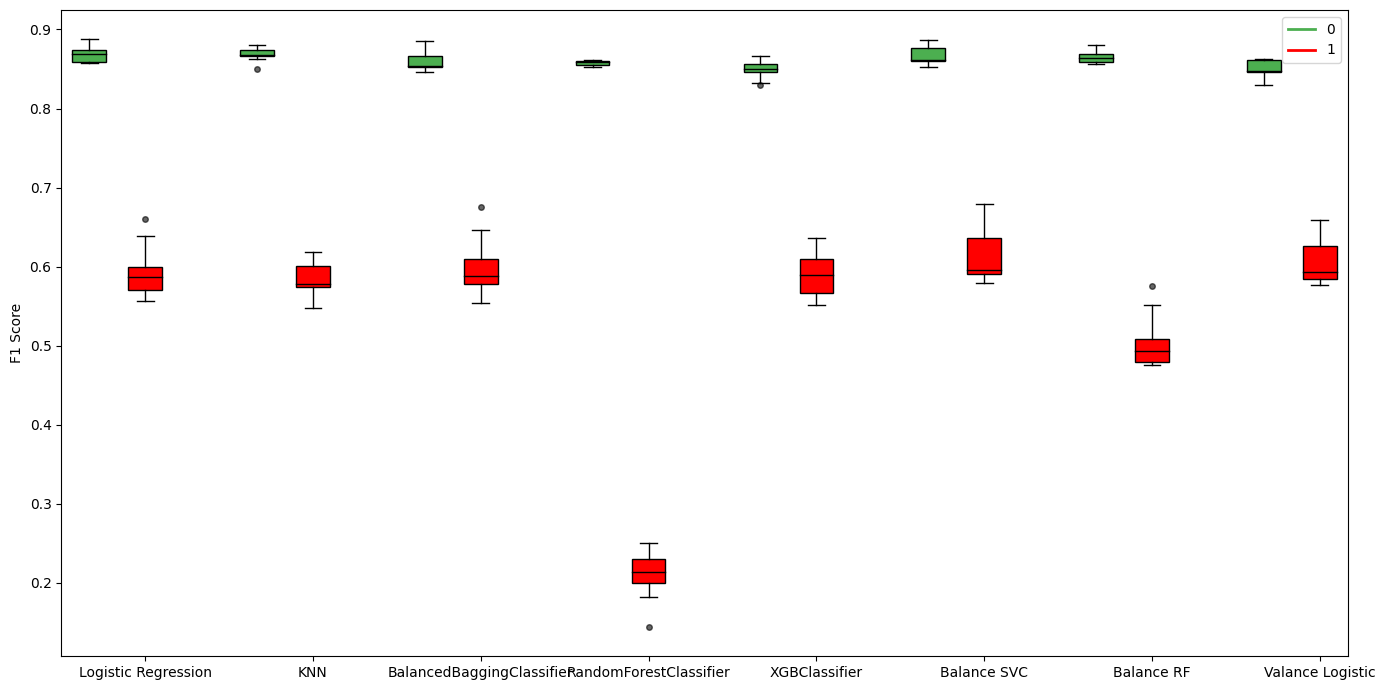

In [ ]:
boxplot(X_train_tfidf, y_train)

To address the issue of dataset imbalance, under-sampling and oversampling techniques were implemented after applying TF-IDF.

<h3 id="train_tf_idf_over" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.2.1. Oversampling</h3>

In [ ]:
# Concatenate 'description_cleaned' and 'host_about_cleaned' columns
X_train['total_cleaned'] = X_train['description_cleaned'] + ' ' + X_train['host_about_cleaned']


# Vectorize the text data
tfidf_vectorizer_over = TfidfVectorizer(max_df=0.85, min_df=2, max_features=1000, stop_words='english')
X_train_tfidf_over = tfidf_vectorizer_over.fit_transform(X_train['total_cleaned'])

# Transform the vectorized data into a dataframe
X_train_tfidf_over = pd.DataFrame(X_train_tfidf_over.todense(), columns=tfidf_vectorizer_over.get_feature_names_out())

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf_over, y_train)

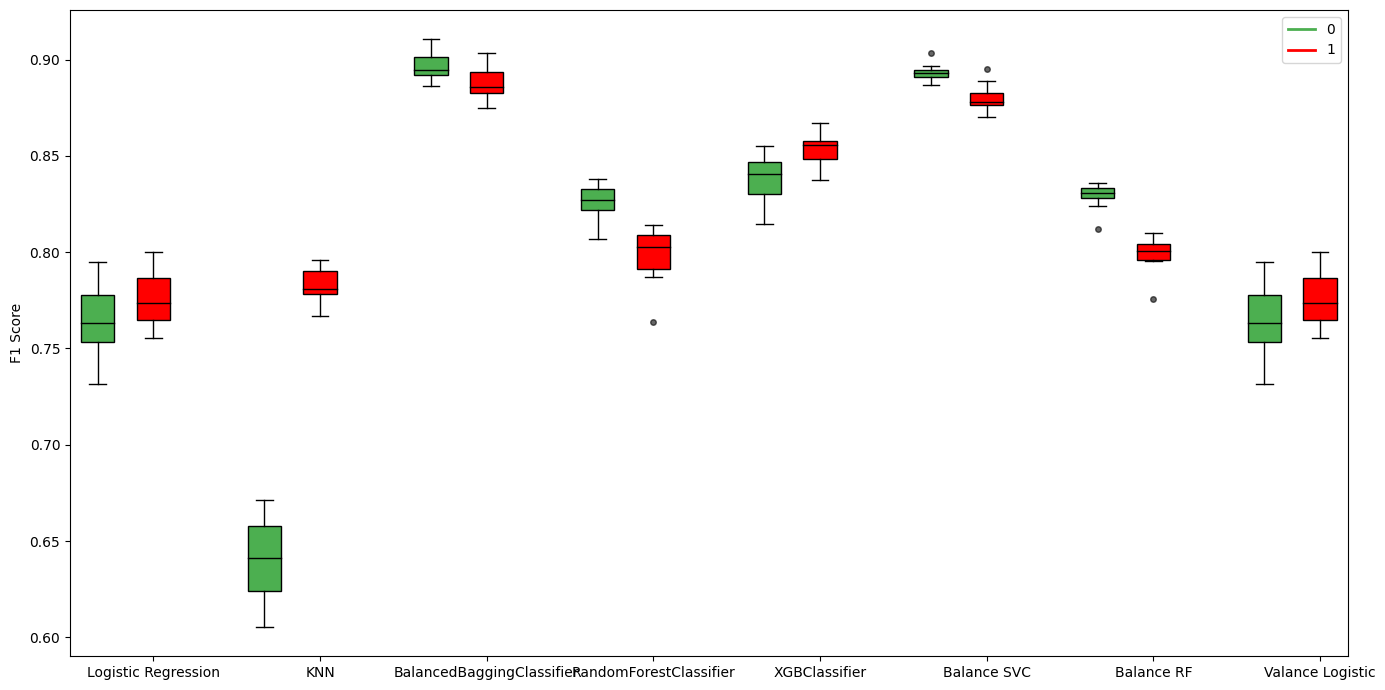

In [ ]:
boxplot_oversample(X_train_smote, y_train_smote)

In [ ]:
# Now we can use X_under and y_under in the training of the model:
logreg = LogisticRegression(**best_params_logistic_tf)
logreg.fit(X_train_smote, y_train_smote)

# Vectorize the val data using the previously fitted tfidf_vectorizer_over
X_val_tfidf_over = tfidf_vectorizer_over.transform(X_val['description_cleaned'])

# Now use this X_val_tfidf_over for predictions
y_pred_tfidf = logreg.predict(X_val_tfidf_over)

evaluate_model(y_val, y_pred_tfidf)

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1491
           1       0.45      0.55      0.50       558

    accuracy                           0.70      2049
   macro avg       0.64      0.65      0.64      2049
weighted avg       0.72      0.70      0.71      2049


Confusion Matrix:
[[1120  371]
 [ 250  308]]

Model Evaluation:
Accuracy: 0.697
Precision: 0.454
Recall: 0.552
F1 Score: 0.498
ROC-AUC Score: 0.652


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



<h3 id="train_tf_idf_under" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.2.2. Undersampling</h3>

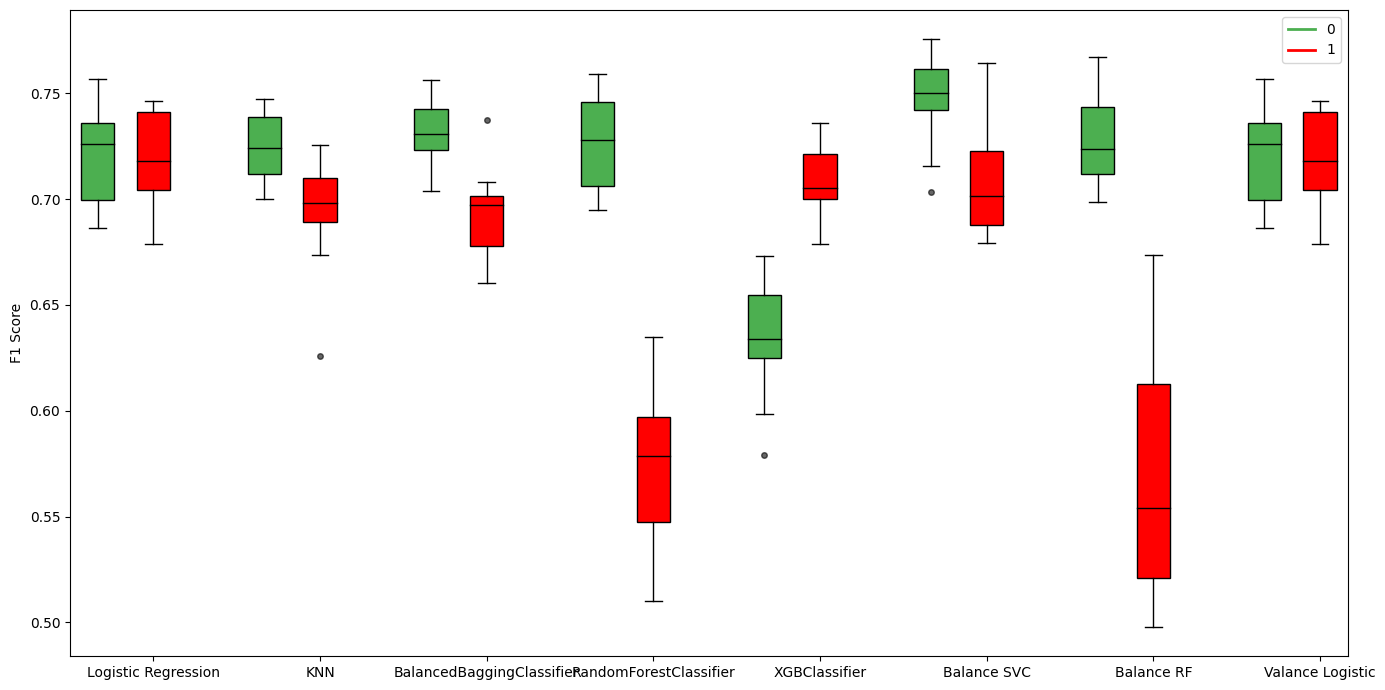

In [ ]:
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_under, y_under = undersample.fit_resample(X_train_tfidf, y_train)

boxplot(X_under, y_under)

<h3 id="train_word_to_vec" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.3. Word2Vec</h3>

In [ ]:
# Tokenize the text data
tokenizer = nltk.tokenize.WordPunctTokenizer()
X_train_tokenized = X_train.apply(lambda row: tokenizer.tokenize(row['description_cleaned']) + tokenizer.tokenize(row['host_about_cleaned']), axis=1)
X_val_tokenized = X_val.apply(lambda row: tokenizer.tokenize(row['description_cleaned']) + tokenizer.tokenize(row['host_about_cleaned']), axis=1)

# Train the Word2Vec model
model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# Transform the text data to Word2Vec features
X_train_w2v = X_train_tokenized.apply(lambda x: np.mean([model.wv[word] for word in x if word in model.wv], axis=0))
X_val_w2v = X_val_tokenized.apply(lambda x: np.mean([model.wv[word] for word in x if word in model.wv], axis=0))

# Convert the Series of lists to a 2D numpy array
X_train_w2v = np.array(X_train_w2v.tolist())
X_val_w2v = np.array(X_val_w2v.tolist())

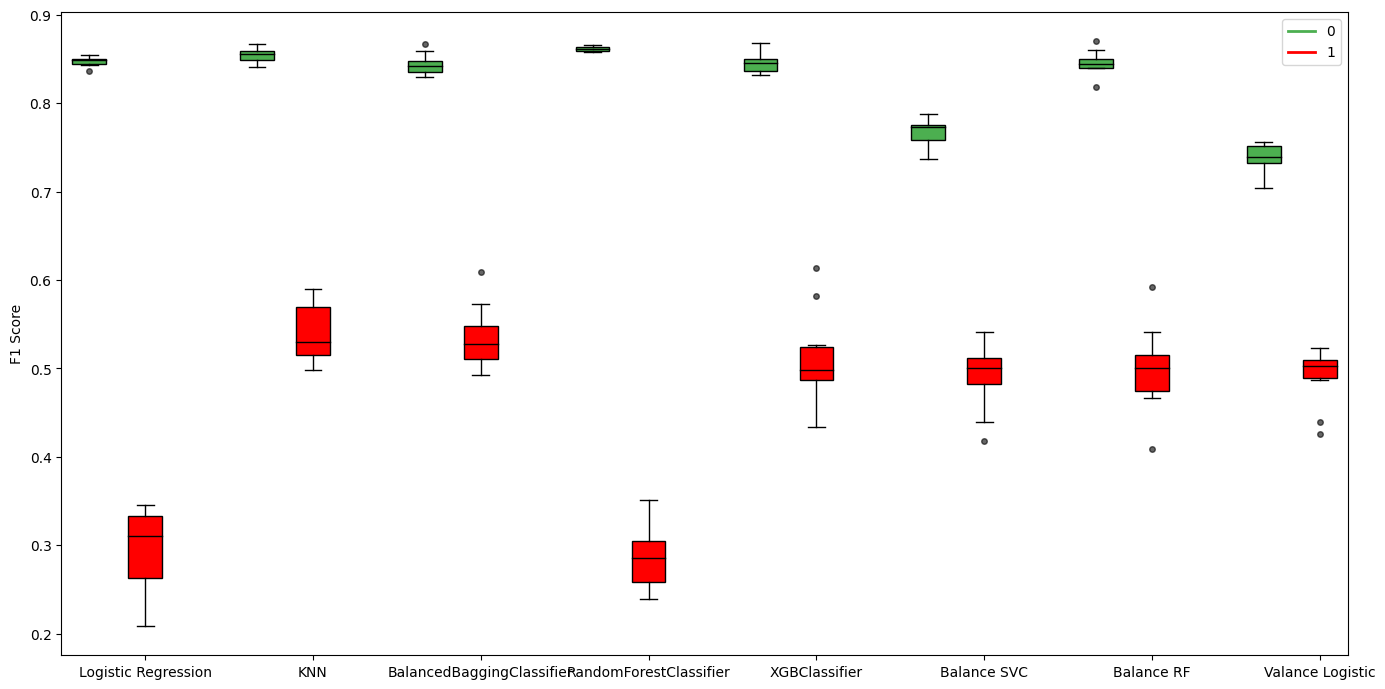

In [ ]:
boxplot(X_train_w2v, y_train)

<h3 id="train_bert_tok" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.4. BERT Tokenizer</h3>

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Set the model in evaluation mode to deactivate the DropOut modules
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU if available
model = model.to(device)

# Define a batch size
batch_size = 32

def calculate_embeddings(texts):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Create batch tensors with padding for uneven batches
        batch_input_ids = []
        batch_attention_mask = []

        for text in batch_texts:
            if text:
                encoded_input = tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                    return_tensors='pt',  # Return PyTorch tensors
                    max_length=512,  # Truncate texts to this length
                    padding='max_length',  # Pad shorter sentences
                    return_attention_mask=True,
                    truncation=True
                )

                # Add the encoded results to the batch lists
                batch_input_ids.append(encoded_input['input_ids'])
                batch_attention_mask.append(encoded_input['attention_mask'])
            else:
                # Append zero tensors for empty texts
                batch_input_ids.append(torch.zeros((1, 512), dtype=torch.long))
                batch_attention_mask.append(torch.zeros((1, 512), dtype=torch.long))

        # Convert lists to tensors
        batch_input_ids = torch.cat(batch_input_ids, dim=0)
        batch_attention_mask = torch.cat(batch_attention_mask, dim=0)

        # Move tensors to GPU if available
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)

        # Predict hidden states features for each layer
        with torch.no_grad():
            outputs = model(batch_input_ids, batch_attention_mask)
            hidden_states = outputs[2]

        # Concatenate the tensors for all layers.
        token_embeddings = torch.stack(hidden_states, dim=0)

        # Swap dimensions 0 and 1.
        token_embeddings = token_embeddings.permute(1,2,0,3)

        # Take the first token ([CLS]) from the embeddings of the last layer
        sentence_embeddings = token_embeddings[:, 0, -1]

        # Move embeddings to CPU and convert to numpy arrays
        sentence_embeddings = sentence_embeddings.cpu().numpy()
        embeddings.extend(sentence_embeddings)

    return embeddings

# Calculate BERT embeddings for 'description_cleaned' and 'host_about_cleaned'
columns_to_embed = ['description_cleaned', 'host_about_cleaned']
for column in columns_to_embed:
    X_train[column + '_bert'] = calculate_embeddings(X_train[column].tolist())
    X_val[column + '_bert'] = calculate_embeddings(X_val[column].tolist())

X_train_combined_bert = np.hstack((np.vstack(X_train['description_cleaned_bert']),
                                   np.vstack(X_train['host_about_cleaned_bert'])))

X_val_combined_bert = np.hstack((np.vstack(X_val['description_cleaned_bert']),
                                 np.vstack(X_val['host_about_cleaned_bert'])))

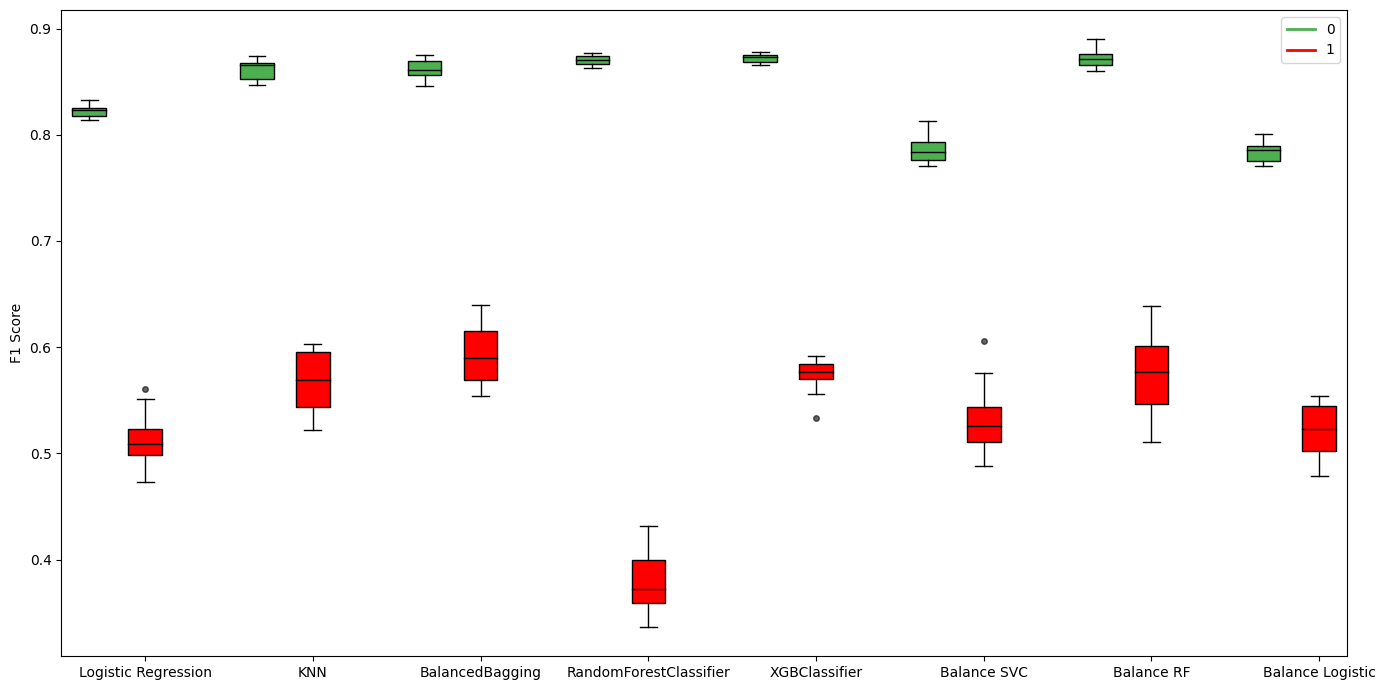

In [ ]:
boxplot(X_train_combined_bert, y_train)

<h3 id="train_roberta_tok" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.5. roBERTa Tokenizer</h3>

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Load pre-trained model (weights)
model = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)

# Set the model in evaluation mode to deactivate the DropOut modules
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU if available
model = model.to(device)

# Define a batch size
batch_size = 32

def calculate_embeddings(texts):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Create batch tensors with padding for uneven batches
        batch_input_ids = []
        batch_attention_mask = []

        for text in batch_texts:
            if text:
                encoded_input = tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                    return_tensors='pt',  # Return PyTorch tensors
                    max_length=512,  # Truncate texts to this length
                    padding='max_length',  # Pad shorter sentences
                    return_attention_mask=True,
                    truncation=True
                )

                # Add the encoded results to the batch lists
                batch_input_ids.append(encoded_input['input_ids'])
                batch_attention_mask.append(encoded_input['attention_mask'])
            else:
                # Append zero tensors for empty texts
                batch_input_ids.append(torch.zeros((1, 512), dtype=torch.long))
                batch_attention_mask.append(torch.zeros((1, 512), dtype=torch.long))

        # Convert lists to tensors
        batch_input_ids = torch.cat(batch_input_ids, dim=0)
        batch_attention_mask = torch.cat(batch_attention_mask, dim=0)

        # Move tensors to GPU if available
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)

        # Predict hidden states features for each layer
        with torch.no_grad():
            outputs = model(batch_input_ids, batch_attention_mask)
            hidden_states = outputs[2]

        # Concatenate the tensors for all layers.
        token_embeddings = torch.stack(hidden_states, dim=0)

        # Swap dimensions 0 and 1.
        token_embeddings = token_embeddings.permute(1,2,0,3)

        # Take the first token ([CLS]) from the embeddings of the last layer
        sentence_embeddings = token_embeddings[:, 0, -1]

        # Move embeddings to CPU and convert to numpy arrays
        sentence_embeddings = sentence_embeddings.cpu().numpy()
        embeddings.extend(sentence_embeddings)

    return embeddings

# Calculate RoBERTa embeddings for 'description_cleaned' and 'host_about_cleaned'
columns_to_embed = ['description_cleaned', 'host_about_cleaned']
for column in columns_to_embed:
    X_train[column + '_roberta'] = calculate_embeddings(X_train[column].tolist())
    X_val[column + '_roberta'] = calculate_embeddings(X_val[column].tolist())

X_train_combined_roberta = np.hstack((np.vstack(X_train['description_cleaned_roberta']),
                                   np.vstack(X_train['host_about_cleaned_roberta'])))

X_val_combined_roberta = np.hstack((np.vstack(X_val['description_cleaned_roberta']),
                                 np.vstack(X_val['host_about_cleaned_roberta'])))

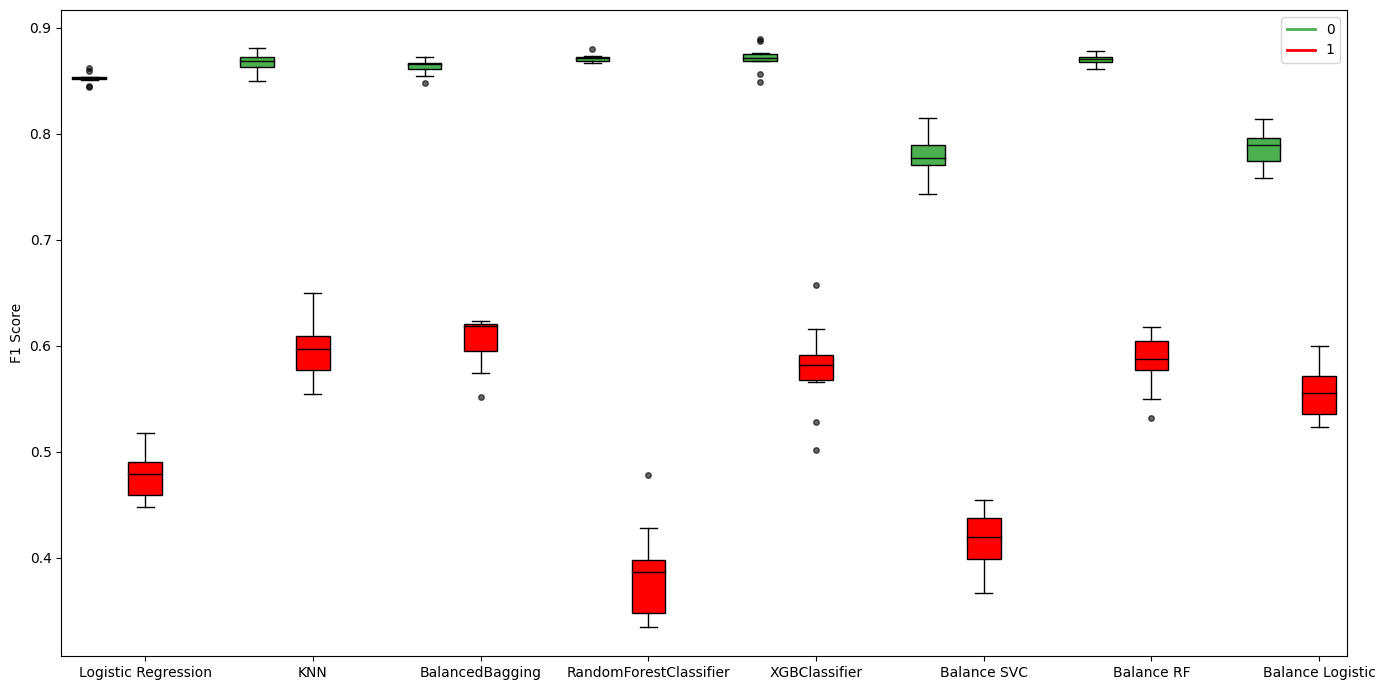

In [ ]:
boxplot(X_train_combined_roberta, y_train)

<h3 id="train_host_tfidf" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.6. Host About (TF-IDF)</h3>

In [ ]:
# Initialize the TF-IDF vectorizer
word_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 1)) #a word that appears more than 80% of the text will not appear

# Fit and transform 'host_about_cleaned'
word_tfidf.fit(X_train['host_about_cleaned'])
X_train_tfidf = word_tfidf.transform(X_train['host_about_cleaned'])
X_val_tfidf = word_tfidf.transform(X_val['host_about_cleaned'])


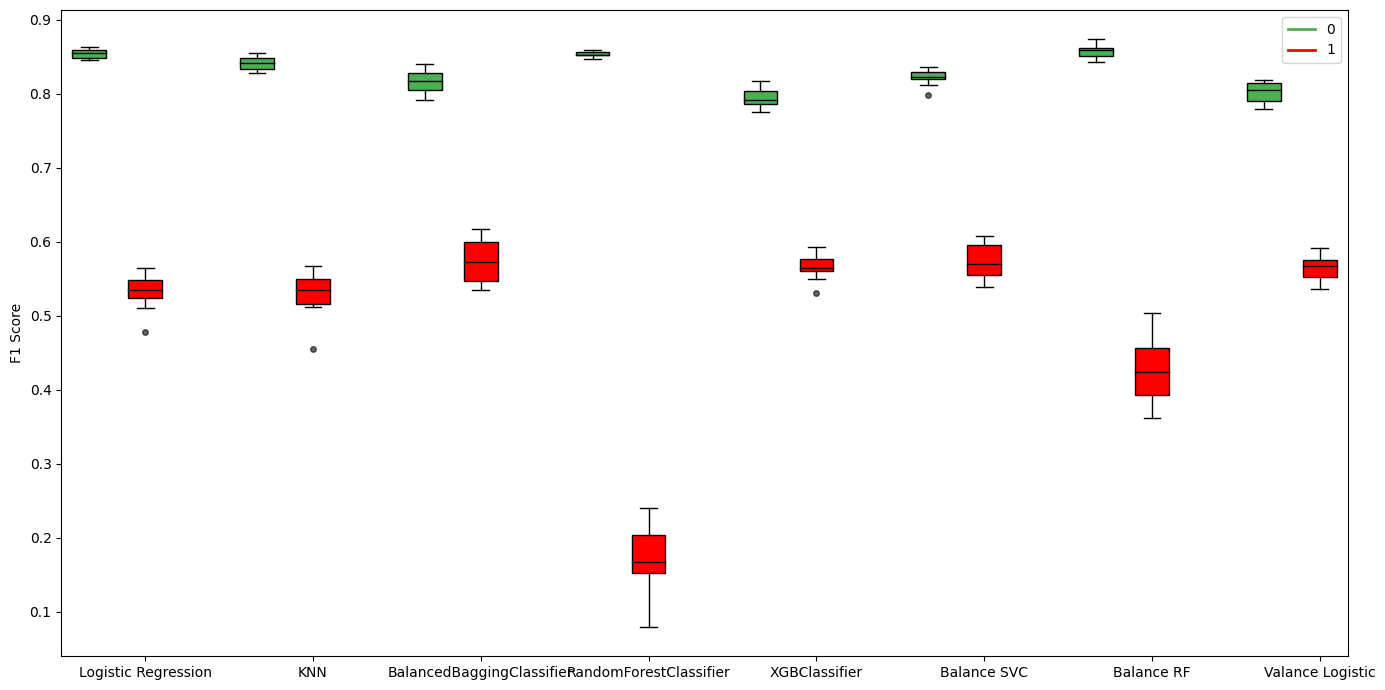

In [ ]:
boxplot(X_train_tfidf, y_train)

<h3 id="train_desc_tfidf" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.7. Description (TF-IDF)</h3>

In [ ]:
# Initialize the TF-IDF vectorizer
word_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 1)) #a word that appears more than 80% of the text will not appear

# Fit and transform 'host_about_cleaned'
word_tfidf.fit(X_train['description_cleaned'])
X_train_tfidf = word_tfidf.transform(X_train['description_cleaned'])
X_val_tfidf = word_tfidf.transform(X_val['description_cleaned'])


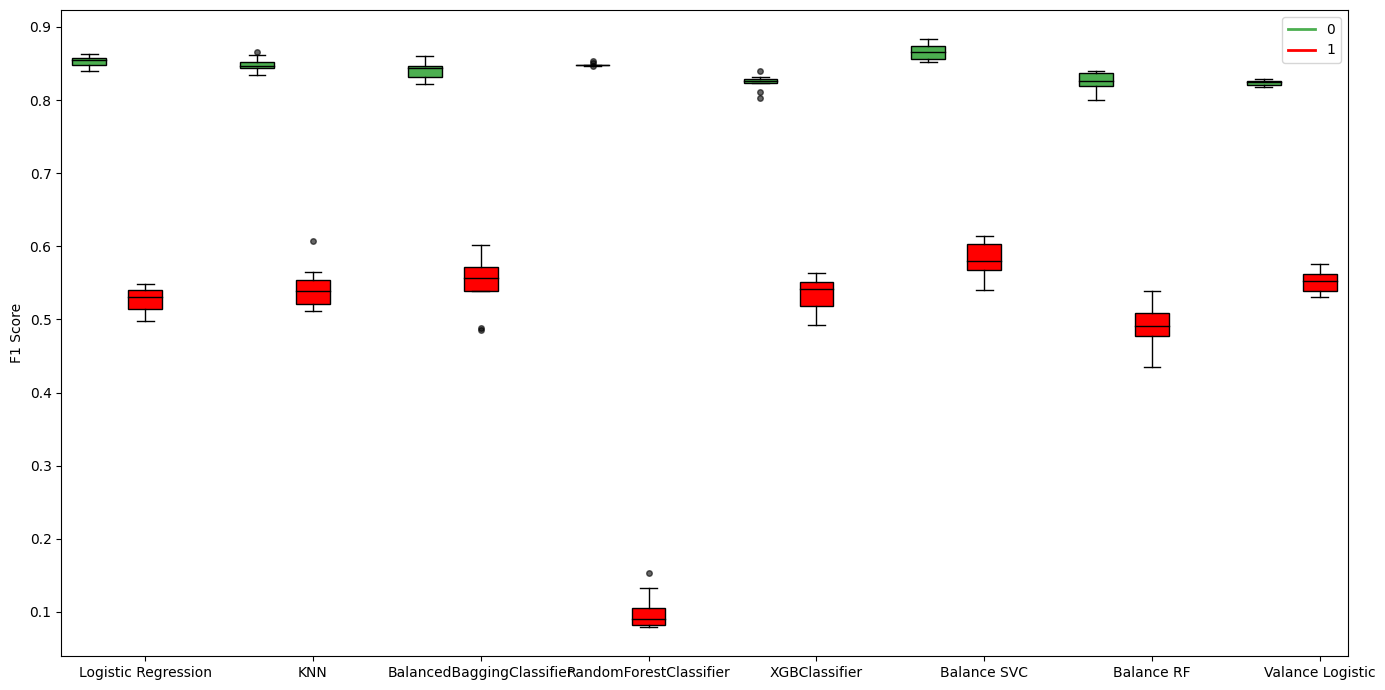

In [ ]:
boxplot(X_train_tfidf, y_train)

<h3 id="train_trans_tfidf" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.1.8. Translated (TF-IDF)</h3>

In [ ]:
# Separate the target variable
X = translated[['description_cleaned', 'host_about_cleaned']]
y = translated['unlisted']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=translated['unlisted'])

# Confirm the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("val set shape:", X_val.shape, y_val.shape)

Training set shape: (9372, 2) (9372,)
val set shape: (3124, 2) (3124,)


In [ ]:
# Initialize the TF-IDF vectorizer
word_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 1)) #a word that appears more than 80% of the text will not appear

# Fit and transform 'text1'
word_tfidf.fit(X_train['description_cleaned'])
X_train_text1_tfidf = word_tfidf.transform(X_train['description_cleaned'])
X_val_text1_tfidf = word_tfidf.transform(X_val['description_cleaned'])

# Fit and transform 'text2'
word_tfidf.fit(X_train['host_about_cleaned'])
X_train_text2_tfidf = word_tfidf.transform(X_train['host_about_cleaned'])
X_val_text2_tfidf = word_tfidf.transform(X_val['host_about_cleaned'])

X_train_tfidf = hstack([X_train_text1_tfidf, X_train_text2_tfidf])
X_val_tfidf = hstack([X_val_text1_tfidf, X_val_text2_tfidf])


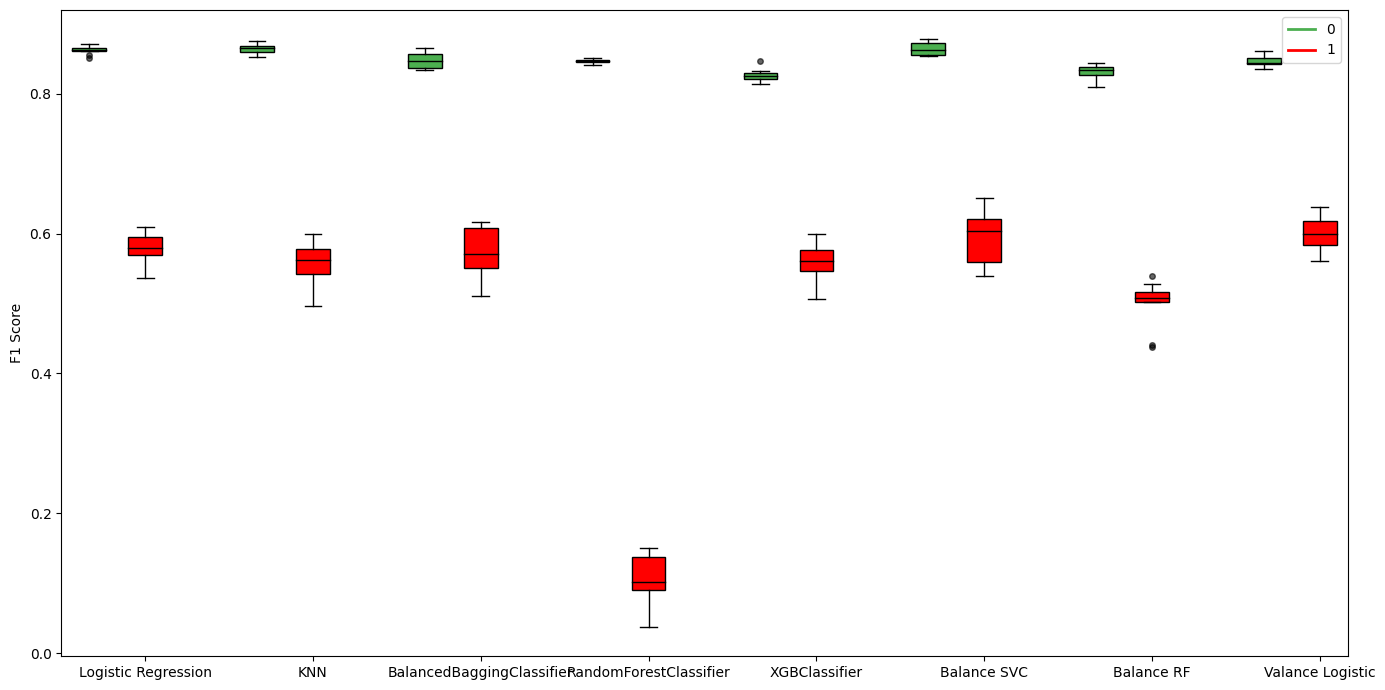

In [ ]:
boxplot(X_train_tfidf, y_train)


<h1 id="model_train_mul_unfil" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">3.2. Multiple Languages Unfiltered</h1>

In this section, the data used contains stop words.

In [ ]:
# Separate the target variable
X = unfiltered[['description_cleaned', 'host_about_cleaned']]
y = unfiltered['unlisted']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=unfiltered['unlisted'])

<h3 id="train_mbert_tok" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.2.1. M-BERT Tokenizer</h3>

In [ ]:
# Combine description and host_about columns
X_train['description_host'] = X_train['description_cleaned'] + ' ' + X_train['host_about_cleaned']

X_train_combined_mbert = tokenize_mbert('description_host',1)

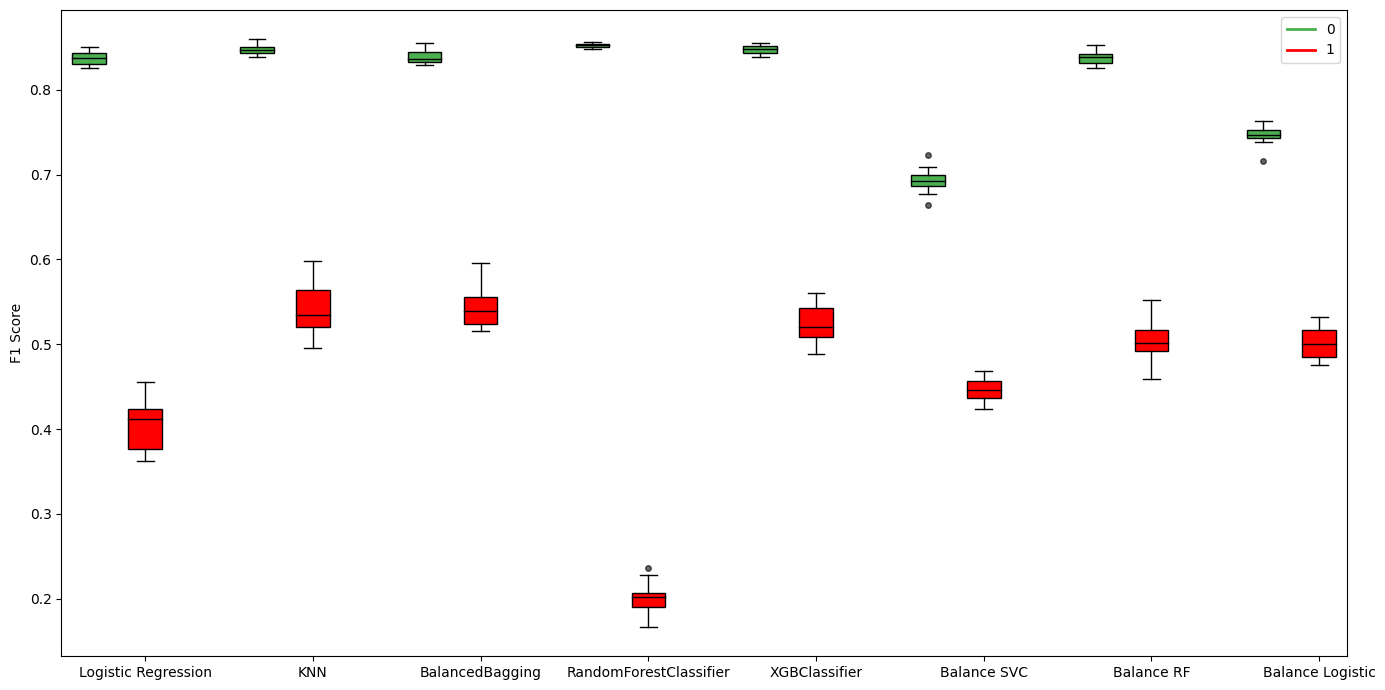

In [ ]:
boxplot(X_train_combined_mbert, y_train)

<h3 id="train_xlmroberta_tok" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.2.2. XLM-roBERTa Tokenizer</h3>

In [ ]:
X_train_combined_xlmr = tokenize_xlm_roberta('description_host',1)

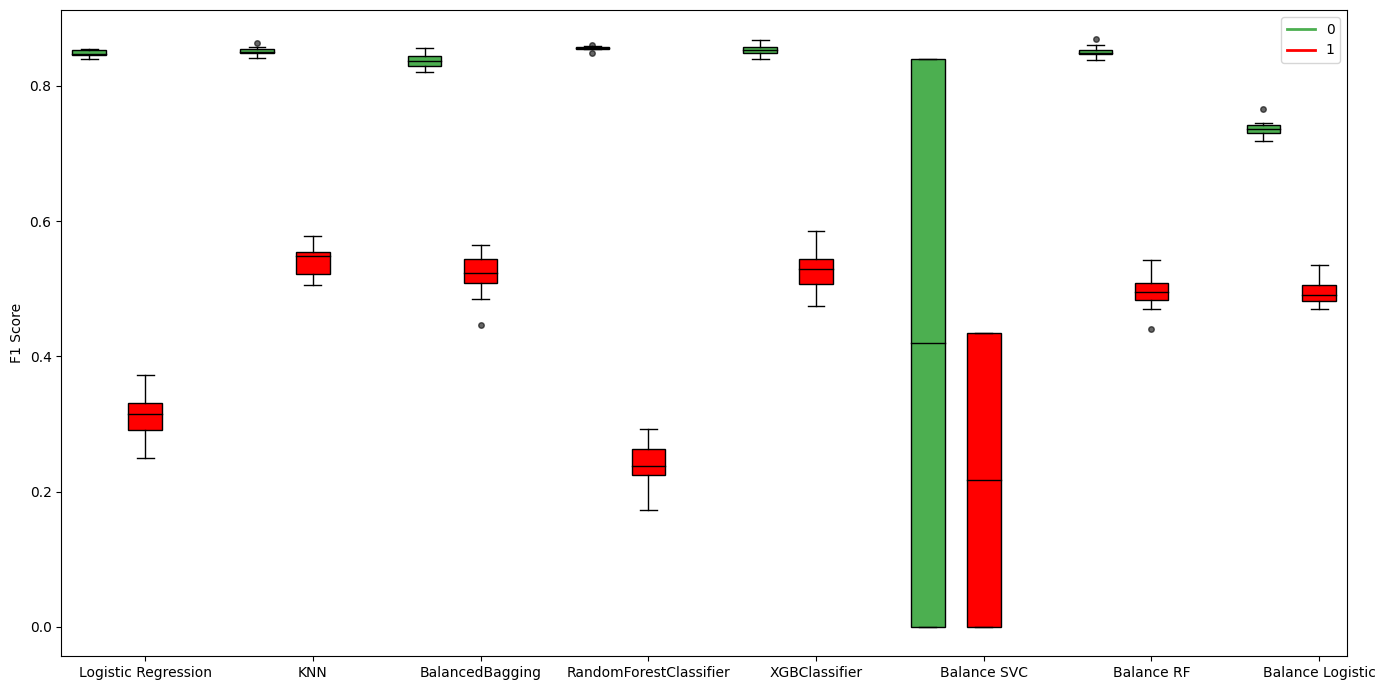

In [ ]:
boxplot(X_train_combined_xlmr, y_train)

<h1 id="model_train_mul_fil" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">3.3. Multiple Languages Filtered</h1>

In [ ]:
# Separate the target variable
X = withoutstopwords[['description_cleaned', 'host_about_cleaned']]
y = withoutstopwords['unlisted']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=withoutstopwords['unlisted'])

# Combine description and host_about columns
X_train['description_host'] = X_train['description_cleaned'] + ' ' + X_train['host_about_cleaned']

In an attempt to improve performance of the models in the last section, they were also tested with a corporus that does not contain any stopwords.

<h3 id="train_fil_mbert_tok" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.3.1. M-BERT Tokenizer</h3>

In [ ]:
X_train_combined_mbert = tokenize_mbert('description_host',1)

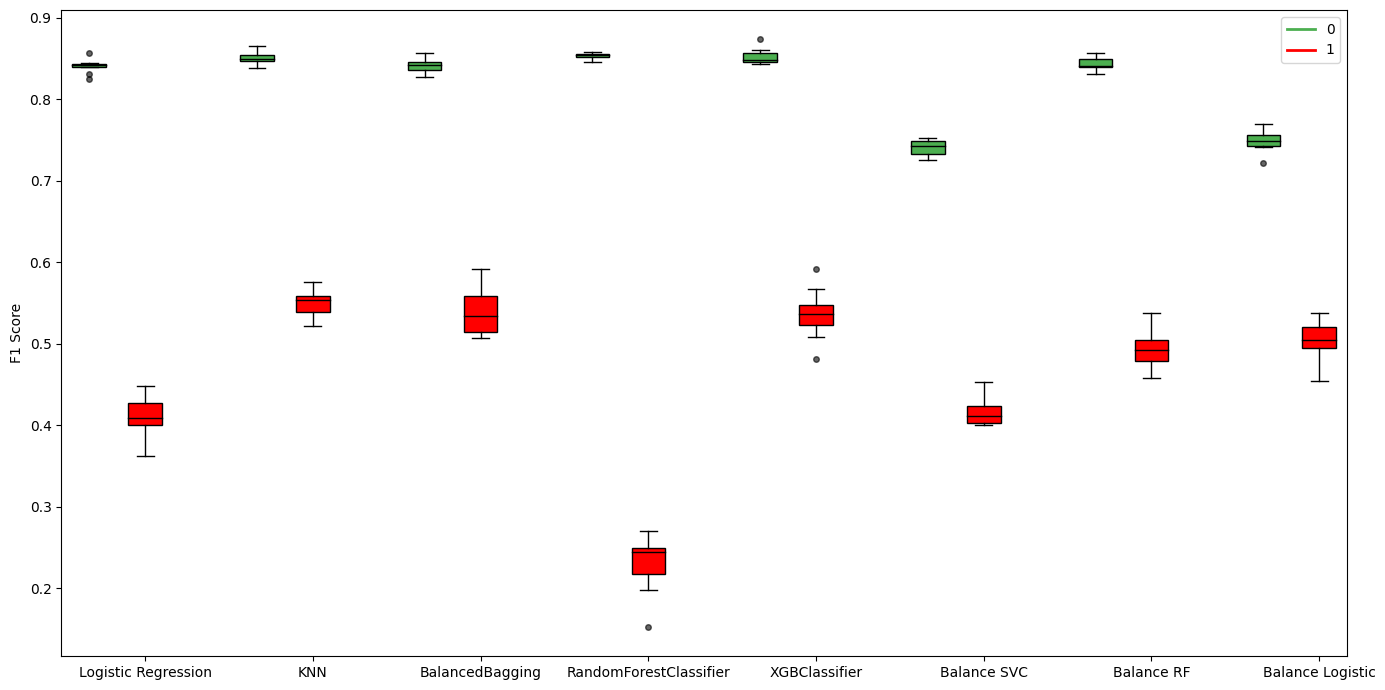

In [ ]:
boxplot(X_train_combined_mbert, y_train)

<h3 id="train_fil_xlmroberta_tok" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.3.2. XLM-roBERTa Tokenizer</h3>

In [ ]:
X_train_combined_xlmr = tokenize_xlm_roberta('description_host',1)

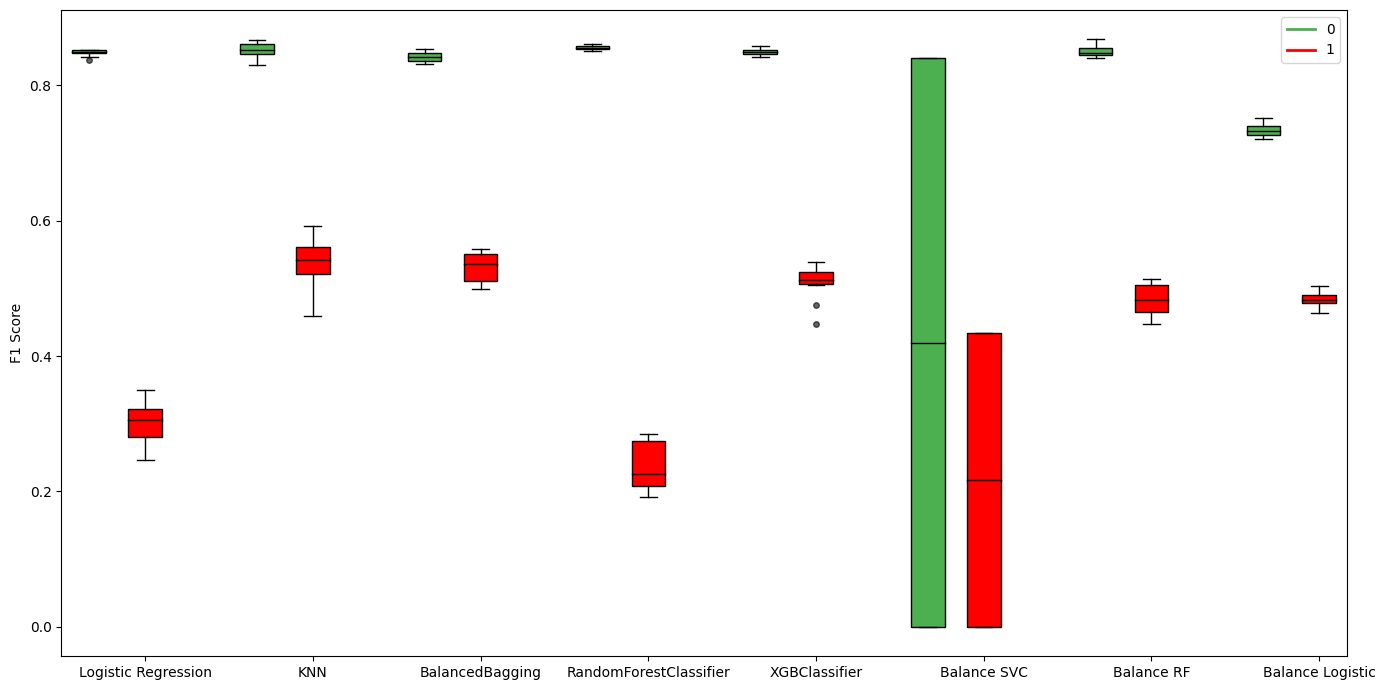

In [ ]:
boxplot(X_train_combined_xlmr, y_train)

The inclusion or exclusion of stopwords did not show a significant difference in performance.

<h1 id="best_model_train" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">3.4. Finding the Best Model</h1>

In order to optimize the solution and determine the best approach, the performance of undersampling, oversampling, and combinations of both methods were compared using the Balanced Bagging Classifier with the best parameters obtained from grid search.

Furthermore, it was tested the performance of two pre-trained models: M-BERT and DistilBERT.

<h3 id="train_roberta_underover" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.4.1. roBERTa Undersampling + Oversampling</h3>

In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(final_df_merged[['description_host']],
                                                  final_df_merged['unlisted'],
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=final_df_merged['unlisted'])

X_train_combined_xlmr, X_val_combined_xlmr = tokenize_xlm_roberta('description_host',2)




In [ ]:
# Percentages in the training set
y_train_percentages = round(y_train.value_counts(normalize=True) * 100,2)

# Percentages in the validation set
y_val_percentages = y_val.value_counts(normalize=True) * 100

print("Percentages in the training set:\n", y_train_percentages)
print("\nPercentages in the validation set:\n", y_val_percentages)


Percentages in the training set:
 0    72.29
1    27.71
Name: unlisted, dtype: float64

Percentages in the validation set:
 0    72.28
1    27.72
Name: unlisted, dtype: float64


In [ ]:
# Train the model
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_combined_xlmr, y_train)

y_pred_host = bbc_classifier_host.predict(X_val_combined_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1807
           1       0.61      0.46      0.53       693

    accuracy                           0.77      2500
   macro avg       0.71      0.67      0.69      2500
weighted avg       0.75      0.77      0.76      2500


Confusion Matrix:
[[1599  208]
 [ 372  321]]

Model Evaluation:
Accuracy: 0.768
Precision: 0.607
Recall: 0.463
F1 Score: 0.525
ROC-AUC Score: 0.674


In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy='majority')

# Perform undersampling for the host data
X_train_host_count, y_train_host = undersample.fit_resample(X_train_combined_xlmr, y_train)

# Train the model
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_host_count, y_train_host)

y_pred_host = bbc_classifier_host.predict(X_val_combined_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1807
           1       0.47      0.63      0.54       693

    accuracy                           0.70      2500
   macro avg       0.65      0.68      0.66      2500
weighted avg       0.73      0.70      0.71      2500


Confusion Matrix:
[[1314  493]
 [ 257  436]]

Model Evaluation:
Accuracy: 0.7
Precision: 0.469
Recall: 0.629
F1 Score: 0.538
ROC-AUC Score: 0.678


In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy=0.5)

# Perform undersampling for the host data
X_train_host_count, y_train_host = undersample.fit_resample(X_train_combined_xlmr, y_train)

# Train the model
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_host_count, y_train_host)

y_pred_host = bbc_classifier_host.predict(X_val_combined_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1807
           1       0.57      0.51      0.54       693

    accuracy                           0.76      2500
   macro avg       0.69      0.68      0.68      2500
weighted avg       0.75      0.76      0.75      2500


Confusion Matrix:
[[1537  270]
 [ 341  352]]

Model Evaluation:
Accuracy: 0.756
Precision: 0.566
Recall: 0.508
F1 Score: 0.535
ROC-AUC Score: 0.679


**Oversample**

In [ ]:
# Apply SMOTE to the training data (after vectorization)
smote = SMOTE(random_state=42)
X_train_smote_host, y_train_smote_host = smote.fit_resample(X_train_combined_xlmr, y_train)


# Train the second model using host data
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_smote_host, y_train_smote_host)

y_pred_host = bbc_classifier_host.predict(X_val_combined_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.80      0.89      0.85      1807
           1       0.61      0.43      0.51       693

    accuracy                           0.77      2500
   macro avg       0.71      0.66      0.68      2500
weighted avg       0.75      0.77      0.75      2500


Confusion Matrix:
[[1616  191]
 [ 393  300]]

Model Evaluation:
Accuracy: 0.766
Precision: 0.611
Recall: 0.433
F1 Score: 0.507
ROC-AUC Score: 0.664


**Undersample + Oversampling**

In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy=0.40)

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(X_train_combined_xlmr, y_train)


# Apply SMOTE to the training data (after vectorization)
smote = SMOTE(random_state=42)
X_train_smote_host, y_train_smote_host = smote.fit_resample(X_train_res, y_train_res)


In [ ]:
# Train the second model using host data
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_smote_host, y_train_smote_host)

y_pred_host = bbc_classifier_host.predict(X_val_combined_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1807
           1       0.64      0.44      0.52       693

    accuracy                           0.77      2500
   macro avg       0.72      0.67      0.68      2500
weighted avg       0.76      0.77      0.76      2500


Confusion Matrix:
[[1634  173]
 [ 391  302]]

Model Evaluation:
Accuracy: 0.774
Precision: 0.636
Recall: 0.436
F1 Score: 0.517
ROC-AUC Score: 0.67


<h3 id="train_full_mbert" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.4.2. Full M-BERT</h3>

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy='majority')

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(pd.DataFrame(X_train), y_train)

# Ensure all inputs are strings
train_texts_comments = X_train_res['description_host'].apply(str).tolist()
val_texts_comments = X_val['description_host'].apply(str).tolist()

# The labels
train_labels = y_train_res.tolist()
val_labels = y_val.tolist()

# Load pre-trained model and tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize and encode the training texts
train_encodings = tokenizer(train_texts_comments, truncation=True, padding=True)
# Tokenize and encode the validation texts
val_encodings = tokenizer(val_texts_comments, truncation=True, padding=True)

# Convert the encodings to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels))

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels))

# Define training parameters
batch_size = 8
epochs = 6
learning_rate = 2e-5

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    print('epoch:', epoch)
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)

    # Print training progress
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val loss: {val_loss:.4f}")
    print(f"Val accuracy: {val_accuracy:.4f}")
    print("=" * 50)

model.eval()
preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).tolist())


y_pred = np.array(preds)
evaluate_model(val_labels, y_pred)

epoch: 0
Epoch 1/6
Train loss: 0.6777
Val loss: 0.7482
Val accuracy: 0.5120
epoch: 1
Epoch 2/6
Train loss: 0.6422
Val loss: 0.6334
Val accuracy: 0.6636
epoch: 2
Epoch 3/6
Train loss: 0.5890
Val loss: 0.5521
Val accuracy: 0.7428
epoch: 3
Epoch 4/6
Train loss: 0.5286
Val loss: 0.8455
Val accuracy: 0.4804
epoch: 4
Epoch 5/6
Train loss: 0.4382
Val loss: 0.5895
Val accuracy: 0.7168
epoch: 5
Epoch 6/6
Train loss: 0.3478
Val loss: 0.9883
Val accuracy: 0.5964
              precision    recall  f1-score   support

           0       0.89      0.50      0.64      1807
           1       0.39      0.84      0.54       693

    accuracy                           0.60      2500
   macro avg       0.64      0.67      0.59      2500
weighted avg       0.75      0.60      0.61      2500


Confusion Matrix:
[[908 899]
 [110 583]]

Model Evaluation:
Accuracy: 0.596
Precision: 0.393
Recall: 0.841
F1 Score: 0.536
ROC-AUC Score: 0.672


<h3 id="train_full_distilbert" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">3.4.3. Full DistilBERT</h3>

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy='majority')

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(pd.DataFrame(X_train), y_train)

# Ensure all inputs are strings
train_texts_comments = X_train_res['description_host'].apply(str).tolist()
val_texts_comments = X_val['description_host'].apply(str).tolist()

# The labels
train_labels = y_train_res.tolist()
val_labels = y_val.tolist()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize and encode the training texts
train_encodings = tokenizer(train_texts_comments, truncation=True, padding=True)
# Tokenize and encode the validation texts
val_encodings = tokenizer(val_texts_comments, truncation=True, padding=True)

# Convert the encodings to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels))

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels))

# Define training parameters
batch_size = 8
epochs = 5
learning_rate = 2e-5

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    print('epoch:', epoch)
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)

    # Print training progress
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val loss: {val_loss:.4f}")
    print(f"Val accuracy: {val_accuracy:.4f}")
    print("=" * 50)

model.eval()
preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).tolist())


y_pred = np.array(preds)
evaluate_model(val_labels, y_pred)


epoch: 0
Epoch 1/5
Train loss: 0.6581
Val loss: 0.6297
Val accuracy: 0.6500
epoch: 1
Epoch 2/5
Train loss: 0.5812
Val loss: 0.5855
Val accuracy: 0.6968
epoch: 2
Epoch 3/5
Train loss: 0.4924
Val loss: 0.5644
Val accuracy: 0.7332
epoch: 3
Epoch 4/5
Train loss: 0.3916
Val loss: 0.6063
Val accuracy: 0.7308
epoch: 4
Epoch 5/5
Train loss: 0.3085
Val loss: 0.7110
Val accuracy: 0.6992
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      1807
           1       0.47      0.68      0.56       693

    accuracy                           0.70      2500
   macro avg       0.66      0.69      0.66      2500
weighted avg       0.75      0.70      0.71      2500


Confusion Matrix:
[[1279  528]
 [ 224  469]]

Model Evaluation:
Accuracy: 0.699
Precision: 0.47
Recall: 0.677
F1 Score: 0.555
ROC-AUC Score: 0.692


<h1 id="reviewsmodel" style="background-color: #FF5A60; color: white; font-size: 34px; font-weight: bold; padding: 10px;">4. Modeling Train  Reviews Dataset</h1>

Initially, a sample of 50,000 instances was used for efficiency purposes during the exploratory phase, as using the entire dataset would be time-consuming.

<h1 id="model_reviews_samp" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">4.1. Sample</h1>

To handle the problem of a property index having multiple instances two approaches were explored:
- Predict the target for each instance and then the majority prediction for one index is it's final prediction (Majority Vote)
- Merge all comments for for the same index into a single text (Merge)

<h3 id="rev_robert_maj" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">4.1.1. roBERTa Majority Vote</h3>

In [ ]:
# Split data into training and testing sets
X_train, X_val, y_train, y_test = train_test_split(sample_majority[['index', 'comments']], sample_majority['unlisted'], test_size=0.2,
                                                    random_state=42, stratify=sample_majority['unlisted'])

# Save the indices
train_indices = X_train['index']
test_indices = X_val['index']

X_train_combined_xlmr = tokenize_xlm_roberta('comments',1)

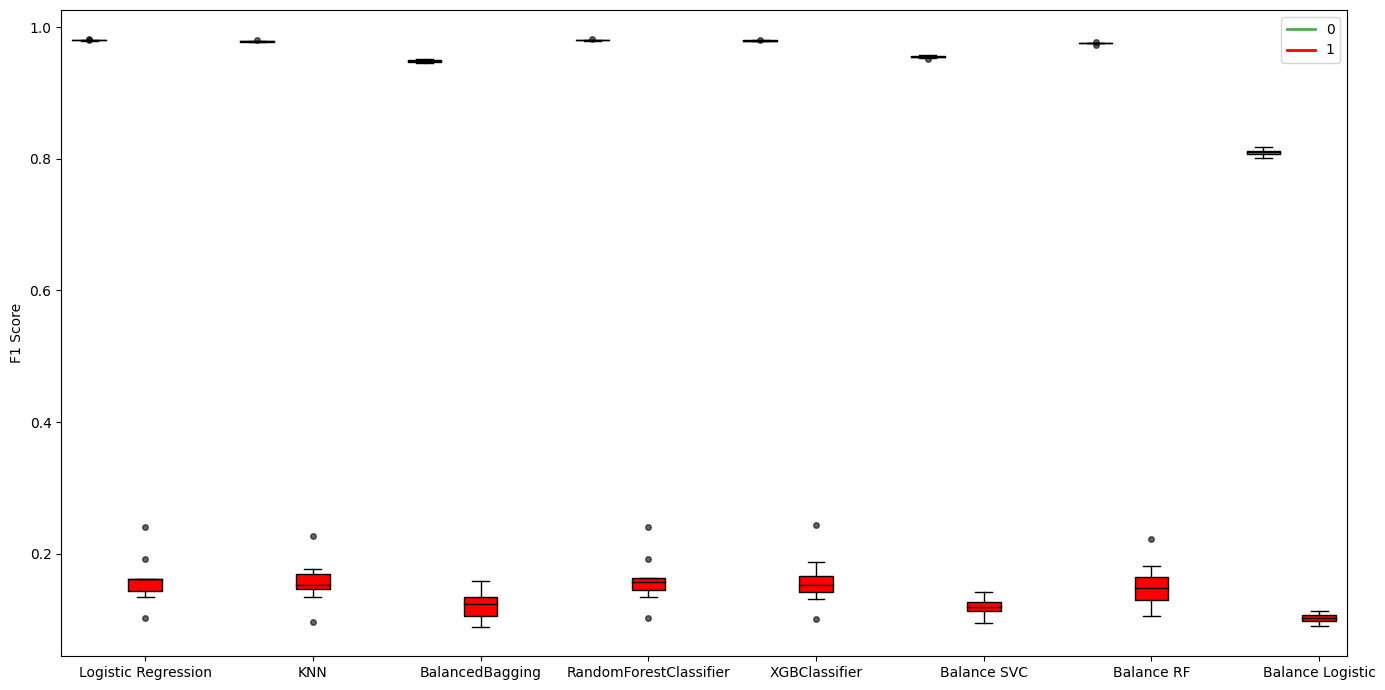

In [ ]:
boxplot(X_train_combined_xlmr, y_train)

<h3 id="rev_robert_merge" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">4.1.2. roBERTa Merge</h3>

In [ ]:
# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(sample_merge[['index', 'comments']], sample_merge['unlisted'],
                                                    stratify=sample_merge['unlisted'], test_size=0.2, random_state=42)

# Save the indices
train_indices = X_train['index']
test_indices = X_val['index']

X_train_combined_xlmr = tokenize_xlm_roberta('comments',1)

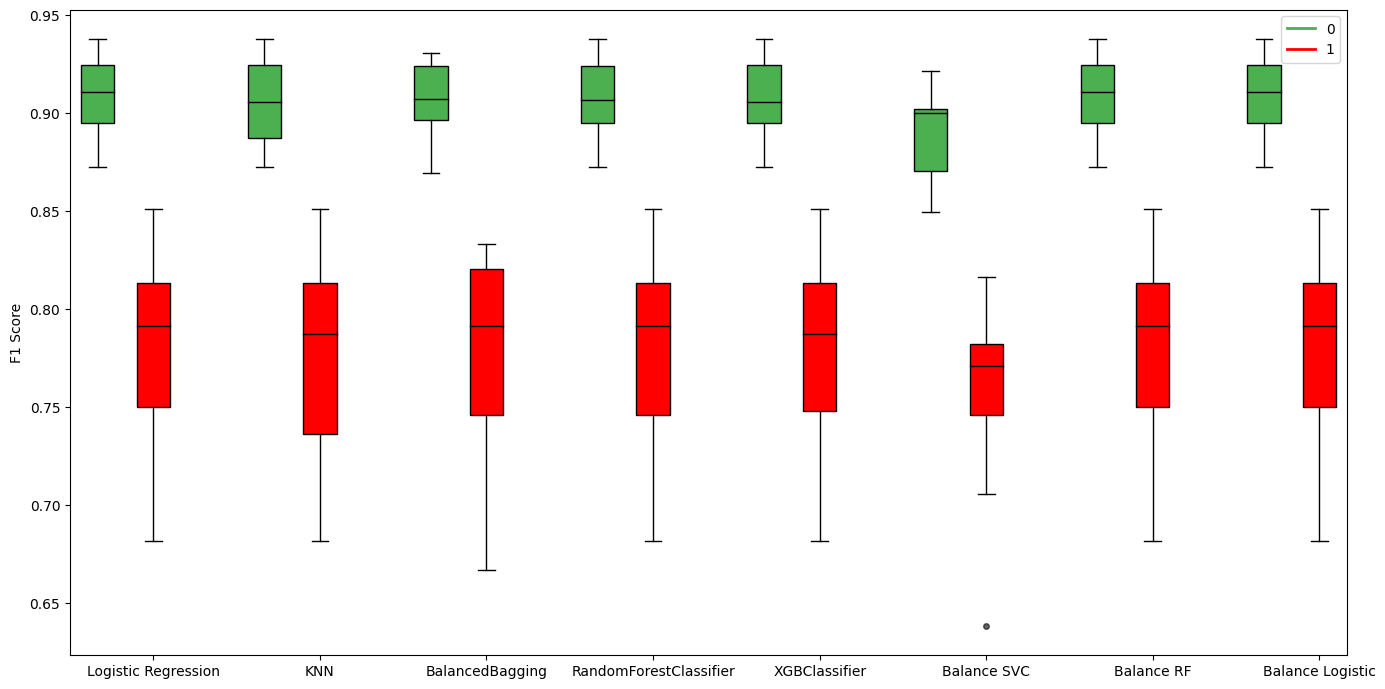

In [ ]:
boxplot(X_train_combined_xlmr, y_train)

The merging approach not only yielded better results but also improved the computational efficiency of the code. Therefore, it was the chosen option for further analysis.

<h1 id="model_reviews_comp" style="background-color: #FF5A60; color: white; font-size: 25px; padding: 10px;">4.2. Complete</h1>

In this section, the train reviews dataset is used in its entirety. Three models were accessed: Balanced Bagging Classifier, M-BERT and DistilBERT.

<h3 id="rev_bbc_merge" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">4.2.1. Balanced Bagging Classifier</h3>

In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(final_df_merged,
    final_df_merged['unlisted'],
    test_size=0.2,
    random_state=42,
    stratify= final_df_merged['unlisted']
)

X_train_xlmr, X_val_xlmr = tokenize_xlm_roberta('comments',2 )

# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy='majority')

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(X_train_xlmr, y_train)

# Train the second model using host data
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_res, y_train_res)

y_pred_host = bbc_classifier_host.predict(X_val_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1807
           1       0.69      0.83      0.76       693

    accuracy                           0.85      2500
   macro avg       0.81      0.85      0.82      2500
weighted avg       0.86      0.85      0.85      2500


Confusion Matrix:
[[1548  259]
 [ 115  578]]

Model Evaluation:
Accuracy: 0.85
Precision: 0.691
Recall: 0.834
F1 Score: 0.756
ROC-AUC Score: 0.845


In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy=0.5)

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(X_train_xlmr, y_train)

# Train the second model using host data
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_res, y_train_res)

y_pred_host = bbc_classifier_host.predict(X_val_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1807
           1       0.70      0.83      0.76       693

    accuracy                           0.85      2500
   macro avg       0.81      0.85      0.83      2500
weighted avg       0.86      0.85      0.86      2500


Confusion Matrix:
[[1558  249]
 [ 119  574]]

Model Evaluation:
Accuracy: 0.853
Precision: 0.697
Recall: 0.828
F1 Score: 0.757
ROC-AUC Score: 0.845


In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy=0.4)

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(X_train_xlmr, y_train)

# Train the second model using host data
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_res, y_train_res)

y_pred_host = bbc_classifier_host.predict(X_val_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1807
           1       0.70      0.83      0.76       693

    accuracy                           0.85      2500
   macro avg       0.81      0.84      0.82      2500
weighted avg       0.86      0.85      0.86      2500


Confusion Matrix:
[[1558  249]
 [ 121  572]]

Model Evaluation:
Accuracy: 0.852
Precision: 0.697
Recall: 0.825
F1 Score: 0.756
ROC-AUC Score: 0.844


In [ ]:
# Apply SMOTE to the training data (after vectorization)
smote = SMOTE(random_state=42)
X_train_smote_host, y_train_smote_host = smote.fit_resample(X_train_xlmr, y_train)

# Train the second model using host data
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_smote_host, y_train_smote_host)

y_pred_host = bbc_classifier_host.predict(X_val_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1807
           1       0.70      0.83      0.76       693

    accuracy                           0.86      2500
   macro avg       0.82      0.85      0.83      2500
weighted avg       0.87      0.86      0.86      2500


Confusion Matrix:
[[1566  241]
 [ 120  573]]

Model Evaluation:
Accuracy: 0.856
Precision: 0.704
Recall: 0.827
F1 Score: 0.76
ROC-AUC Score: 0.847


In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy=0.40)

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(X_train_xlmr, y_train)


# Apply SMOTE to the training data (after vectorization)
smote = SMOTE(random_state=42)
X_train_smote_host, y_train_smote_host = smote.fit_resample(X_train_res, y_train_res)
# Train the second model using host data
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_smote_host, y_train_smote_host)

y_pred_host = bbc_classifier_host.predict(X_val_xlmr)
evaluate_model(y_val, y_pred_host)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1807
           1       0.70      0.83      0.76       693

    accuracy                           0.86      2500
   macro avg       0.82      0.85      0.83      2500
weighted avg       0.87      0.86      0.86      2500


Confusion Matrix:
[[1565  242]
 [ 120  573]]

Model Evaluation:
Accuracy: 0.855
Precision: 0.703
Recall: 0.827
F1 Score: 0.76
ROC-AUC Score: 0.846


<h3 id="rev_full_mbert" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">4.2.2. Full M-BERT</h3>

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(final_df_merged['comments'],
    final_df_merged['unlisted'],
    test_size=0.2,
    random_state=42,
    stratify= final_df_merged['unlisted']
)

In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy=0.5)

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(pd.DataFrame(X_train), y_train)

# Ensure all inputs are strings
train_texts_comments = X_train_res['comments'].apply(str).tolist()
val_texts_comments = X_val.apply(str).tolist()

# The labels
train_labels = y_train_res.tolist()
val_labels = y_val.tolist()

# Load pre-trained model and tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize and encode the training texts
train_encodings = tokenizer(train_texts_comments, truncation=True, padding=True)
# Tokenize and encode the validation texts
val_encodings = tokenizer(val_texts_comments, truncation=True, padding=True)

# Convert the encodings to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels))

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels))

# Define training parameters
batch_size = 8
epochs = 6
learning_rate = 2e-5

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    print('epoch:', epoch)
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)

    # Print training progress
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val loss: {val_loss:.4f}")
    print(f"Val accuracy: {val_accuracy:.4f}")
    print("=" * 50)

model.eval()
preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).tolist())


y_pred = np.array(preds)
evaluate_model(val_labels, y_pred)

epoch: 0
Epoch 1/6
Train loss: 0.3755
Val loss: 0.3880
Val accuracy: 0.8552
epoch: 1
Epoch 2/6
Train loss: 0.3763
Val loss: 0.3850
Val accuracy: 0.8536
epoch: 2
Epoch 3/6
Train loss: 0.3728
Val loss: 0.3870
Val accuracy: 0.8552
epoch: 3
Epoch 4/6
Train loss: 0.3703
Val loss: 0.3802
Val accuracy: 0.8552
epoch: 4
Epoch 5/6
Train loss: 0.3692
Val loss: 0.3874
Val accuracy: 0.8552
epoch: 5
Epoch 6/6
Train loss: 0.3696
Val loss: 0.3769
Val accuracy: 0.8552
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1807
           1       0.70      0.82      0.76       693

    accuracy                           0.86      2500
   macro avg       0.82      0.85      0.83      2500
weighted avg       0.87      0.86      0.86      2500


Confusion Matrix:
[[1567  240]
 [ 122  571]]

Model Evaluation:
Accuracy: 0.855
Precision: 0.704
Recall: 0.824
F1 Score: 0.759
ROC-AUC Score: 0.846


<h3 id="rev_full_distilbert" style="background-color: #FF5A60; color: white; font-size: 20px; padding: 10px;">4.2.3. Full DistilBERT</h3>

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy=0.5)

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(pd.DataFrame(X_train), y_train)

# Ensure all inputs are strings
train_texts_comments = X_train_res['comments'].apply(str).tolist()
val_texts_comments = X_val.apply(str).tolist()

# The labels
train_labels = y_train_res.tolist()
val_labels = y_val.tolist()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize and encode the training texts
train_encodings = tokenizer(train_texts_comments, truncation=True, padding=True)
# Tokenize and encode the validation texts
val_encodings = tokenizer(val_texts_comments, truncation=True, padding=True)

# Convert the encodings to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels))

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels))

# Define training parameters
batch_size = 8
epochs = 5
learning_rate = 2e-5

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    print('epoch:', epoch)
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)

    # Print training progress
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val loss: {val_loss:.4f}")
    print(f"Val accuracy: {val_accuracy:.4f}")
    print("=" * 50)

model.eval()
preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).tolist())


y_pred = np.array(preds)
evaluate_model(val_labels, y_pred)


epoch: 0
Epoch 1/5
Train loss: 0.3744
Val loss: 0.3827
Val accuracy: 0.8552
epoch: 1
Epoch 2/5
Train loss: 0.3669
Val loss: 0.3789
Val accuracy: 0.8532
epoch: 2
Epoch 3/5
Train loss: 0.3651
Val loss: 0.3799
Val accuracy: 0.8556
epoch: 3
Epoch 4/5
Train loss: 0.3617
Val loss: 0.3743
Val accuracy: 0.8540
epoch: 4
Epoch 5/5
Train loss: 0.3569
Val loss: 0.3884
Val accuracy: 0.8512
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1807
           1       0.69      0.84      0.76       693

    accuracy                           0.85      2500
   macro avg       0.81      0.85      0.83      2500
weighted avg       0.87      0.85      0.86      2500


Confusion Matrix:
[[1547  260]
 [ 112  581]]

Model Evaluation:
Accuracy: 0.851
Precision: 0.691
Recall: 0.838
F1 Score: 0.757
ROC-AUC Score: 0.847


<h1 id="ensemble" style="background-color: #FF5A60; color: white; font-size: 34px; font-weight: bold; padding: 10px;">5. Ensemble</h1>

Finally, after all the testing, a ensemble was built using the model that best predicts using the the different datasets. For the train, DistilBERT is used and for the train reviews, Balanced Bagging Classifier was the chosen one.

In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(final_df_merged,
    final_df_merged['unlisted'],
    test_size=0.2,
    random_state=42,
    stratify= final_df_merged['unlisted']
)

X_train_xlmr, X_val_xlmr = tokenize_xlm_roberta('comments',2 )

In [ ]:
# Prepare the undersampler
undersample = RandomUnderSampler(sampling_strategy='majority')

# Perform undersampling
X_train_res, y_train_res = undersample.fit_resample(pd.DataFrame(X_train), y_train)

# Ensure all inputs are strings
train_texts_comments = X_train_res['description_host'].apply(str).tolist()
val_texts_comments = X_val['description_host'].apply(str).tolist()

# The labels
train_labels = y_train_res.tolist()
val_labels = y_val.tolist()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize and encode the training texts
train_encodings = tokenizer(train_texts_comments, truncation=True, padding=True)
# Tokenize and encode the validation texts
val_encodings = tokenizer(val_texts_comments, truncation=True, padding=True)

# Convert the encodings to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels))

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels))

# Define training parameters
batch_size = 8
epochs = 5
learning_rate = 2e-5

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    print('epoch:', epoch)
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)

    # Print training progress
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val loss: {val_loss:.4f}")
    print(f"Val accuracy: {val_accuracy:.4f}")
    print("=" * 50)

model.eval()
preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).tolist())


y_pred = np.array(preds)
evaluate_model(val_labels, y_pred)


epoch: 0
Epoch 1/5
Train loss: 0.6713
Val loss: 0.7012
Val accuracy: 0.5736
epoch: 1
Epoch 2/5
Train loss: 0.5969
Val loss: 0.6634
Val accuracy: 0.6200
epoch: 2
Epoch 3/5
Train loss: 0.5101
Val loss: 0.5736
Val accuracy: 0.7220
epoch: 3
Epoch 4/5
Train loss: 0.4039
Val loss: 0.5967
Val accuracy: 0.7332
epoch: 4
Epoch 5/5
Train loss: 0.2940
Val loss: 0.7079
Val accuracy: 0.6912
              precision    recall  f1-score   support

           0       0.85      0.69      0.76      1807
           1       0.46      0.69      0.55       693

    accuracy                           0.69      2500
   macro avg       0.66      0.69      0.66      2500
weighted avg       0.75      0.69      0.71      2500


Confusion Matrix:
[[1249  558]
 [ 214  479]]

Model Evaluation:
Accuracy: 0.691
Precision: 0.462
Recall: 0.691
F1 Score: 0.554
ROC-AUC Score: 0.691


In [ ]:
# Apply SMOTE to the training data (after vectorization)
smote = SMOTE(random_state=42)
X_train_smote_host, y_train_smote_host = smote.fit_resample(X_train_xlmr, y_train)

# Train the second model using host data
bbc_classifier_host = BalancedBaggingClassifier(**best_params_bag_tf)
bbc_classifier_host.fit(X_train_smote_host, y_train_smote_host)

y_pred_comments = bbc_classifier_host.predict(X_val_xlmr)
evaluate_model(y_val, y_pred_comments)

              precision    recall  f1-score   support

           0       0.93      0.86      0.90      1807
           1       0.70      0.83      0.76       693

    accuracy                           0.85      2500
   macro avg       0.82      0.85      0.83      2500
weighted avg       0.87      0.85      0.86      2500


Confusion Matrix:
[[1563  244]
 [ 120  573]]

Model Evaluation:
Accuracy: 0.854
Precision: 0.701
Recall: 0.827
F1 Score: 0.759
ROC-AUC Score: 0.846


In [ ]:
# Combine predictions using ensemble approach
y_pred_ensemble = (y_pred + y_pred_comments) / 2
y_pred_ensemble = np.round(y_pred_ensemble).astype(int)

# Evaluate ensemble predictions
evaluate_model(y_val, y_pred_ensemble)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1807
           1       0.80      0.61      0.69       693

    accuracy                           0.85      2500
   macro avg       0.83      0.78      0.80      2500
weighted avg       0.85      0.85      0.84      2500


Confusion Matrix:
[[1705  102]
 [ 272  421]]

Model Evaluation:
Accuracy: 0.85
Precision: 0.805
Recall: 0.608
F1 Score: 0.692
ROC-AUC Score: 0.776


In [ ]:
y_pred_ensemble = (0.3 * y_pred + 0.7 * y_pred_comments)
y_pred_ensemble = np.round(y_pred_ensemble).astype(int)
evaluate_model(y_val, y_pred_ensemble)

              precision    recall  f1-score   support

           0       0.93      0.86      0.90      1807
           1       0.70      0.83      0.76       693

    accuracy                           0.85      2500
   macro avg       0.82      0.85      0.83      2500
weighted avg       0.87      0.85      0.86      2500


Confusion Matrix:
[[1563  244]
 [ 120  573]]

Model Evaluation:
Accuracy: 0.854
Precision: 0.701
Recall: 0.827
F1 Score: 0.759
ROC-AUC Score: 0.846


In [ ]:
y_pred_ensemble = (0.7 * y_pred + 0.3 * y_pred_comments)
y_pred_ensemble = np.round(y_pred_ensemble).astype(int)
evaluate_model(y_val, y_pred_ensemble)

              precision    recall  f1-score   support

           0       0.85      0.69      0.76      1807
           1       0.46      0.69      0.55       693

    accuracy                           0.69      2500
   macro avg       0.66      0.69      0.66      2500
weighted avg       0.75      0.69      0.71      2500


Confusion Matrix:
[[1249  558]
 [ 214  479]]

Model Evaluation:
Accuracy: 0.691
Precision: 0.462
Recall: 0.691
F1 Score: 0.554
ROC-AUC Score: 0.691


After evaluating the performance of the the esemble, it was concluded that using only a Balanced Bagging Classifier with the train reviews data leads to better results.